# ***Makine Öğrenimi ile Müşteri Kaybı Tahmini***

Müşteri kaybı (aynı zamanda müşteri terk oranı olarak da bilinir), bir müşterinin bir şirketin ürün veya hizmetlerini kullanmayı bırakması durumunda meydana gelir.

Müşteri kaybı, özellikle gelirlerin büyük ölçüde aboneliklere bağlı olduğu sektörlerde (örneğin bankalar, telefon ve internet servis sağlayıcıları, ücretli TV şirketleri, sigorta firmaları vb.) kârlılığı etkiler. Yeni bir müşteri kazanmanın, mevcut bir müşteriyi elde tutmaktan beş kat daha maliyetli olabileceği tahmin edilmektedir.

Bu nedenle, müşteri kaybı analizi önemlidir, çünkü bir işletmenin:
   * hizmetlerinde yaşanan sorunları (örneğin, düşük kaliteli ürün/hizmet, yetersiz müşteri desteği, yanlış hedef kitle, vb.) belirlemesine,
   * daha yüksek müşteri memnuniyeti ve dolayısıyla daha yüksek müşteri bağlılığına yol açacak doğru stratejik kararlar almasına yardımcı olabilir.

Bu notebook’un amacı, bir bankada müşteri kaybını (churn) anlamak ve tahmin etmektir. Özellikle, başlangıçta Keşifsel Veri Analizi (Exploratory Data Analysis - EDA) gerçekleştirerek müşteri kaybına katkıda bulunan faktörleri belirleyip görselleştireceğiz. Bu analiz, daha sonra müşterinin kaybedilip kaybedilmeyeceğini tahmin etmek için Makine Öğrenimi modelleri oluşturmamıza yardımcı olacaktır.

Bu problem tipik bir sınıflandırma (classification) görevidir. Görev, makine öğrenimi modellerimizi optimize etmek için hangi performans metriğini kullanacağımızı belirtmemektedir. Banka için pozitif sınıfa (kaybedecek müşteriler) ait örneklerin doğru sınıflandırılması daha kritik olduğu için "recall" metriğini kullanmaya karar verdim.

**Kullanılan Beceriler,**
Keşifsel Veri Analizi (EDA),
Veri Görselleştirme,
Veri Ön İşleme (Özellik Seçimi, Kategorik Özelliklerin Kodlanması, Özellik Ölçekleme),
Sınıf Dengesizliğini Ele Alma (SMOTE),
Model Ayarlama (Tuning),
Kullanılan Modeller,
Logistic Regression (Lojistik Regresyon),
Support Vector Machines (Destek Vektör Makineleri),
Random Forests (Rastgele Ormanlar),
Gradient Boosting (Gradyan Artırma),
XGBoost,
Light Gradient Boosting Machine (LightGBM),

# *ABOUT THE DATASET*

1- **RowNumber**: Verideki her bir müşteriye karşılık gelen sıra numarası.  
2- **CustomerId**: Müşteriye özgü benzersiz kimlik numarası.  
3- **Surname**: Müşterinin soyadı.  
4- **CreditScore**: Müşterinin kredi puanı.  
5- **Geography**: Müşterinin bulunduğu coğrafi bölge (örneğin, ülke).  
6- **Gender**: Müşterinin cinsiyeti (Male/Female).  
7- **Age**: Müşterinin yaşı.  
8- **Tenure**: Müşterinin bankadaki üyelik süresi (yıl cinsinden).  
9- **Balance**: Müşterinin bankadaki mevcut hesap bakiyesi (para birimi belirtilmemiştir).  
10- **NumOfProducts**: Müşterinin kullandığı toplam ürün sayısı.  
11- **HasCrCard**: Müşterinin kredi kartına sahip olup olmadığını belirtir (1: Evet, 0: Hayır).  
12- **IsActiveMember**: Müşterinin aktif bir banka müşterisi olup olmadığını belirtir (1: Evet, 0: Hayır).  
13- **EstimatedSalary**: Müşterinin tahmini maaşı.  
14- **Exited**: Müşterinin bankadan ayrılıp ayrılmadığını belirtir (1: Ayrıldı, 0: Ayrılmadı).


# **Import Libraries**

In [136]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.precision', 3) #ondalıklı kısmın sadece 3 basamağı gösterilsin.

#Veri görselleştirme Kütüphaneleri
import matplotlib. pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

# İstatistik
!pip install scipy==1.9.3
from scipy.stats import chi2_contingency
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Makine Öğrenimi için
!pip install scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
!pip install xgboost
from xgboost import XGBClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
!pip install scikit-plot
import scikitplot as skplt


# **Parametreler ve Değişkenler**

Tüm notebook için bazı varsayılan parametreleri ve değişkenleri ayarlayalım.


In [139]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

# Fonksiyonlar

Sürekli bir değişkenin müşteri kaybı (churn) durumu ile ilişkisini incelemek için histogram ve kutu grafiği (boxplot) oluşturmamız gerek. Bunun için fonksiyonumuz:



In [142]:
def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();

Kategorik değişkenlerin dağılımını ve bu değişkenin müşteri kaybı (churn) ile ilişkisini incelemek adına iki farklı grafik oluşturarak kategorik özellikleri analiz etmek ve görselleştirmek için bir fonksiyon yazalım. Özellikle kategorik değişkenlerin dağılımını ve bu değişkenlerin müşteri kaybı (churn) ile ilişkisini incelemek için buna ihtiyacımız olacak.

In [144]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();

Bu fonksiyonumuzun amacı, karışıklık matrisini (confusion matrix) görselleştirmek ve anlamayı kolaylaştırmak. Karışıklık matrisi, bir sınıflandırma modelinin tahmin sonuçlarını analiz etmek için önemli bir araçtır. Bu fonksiyon, matrisin bir heatmap olarak görselleştirilmesini sağlar.

In [146]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);

Sıradaki fonksiyonumuzun amacı, bir makine öğrenmesi modelinin öğrenme eğrisini (learning curve) görselleştirmektir. Öğrenme eğrisi, modelin eğitim seti boyutuna göre performansının nasıl değiştiğini gösterir. Bu, modelin overfitting (aşırı öğrenme) veya underfitting (eksik öğrenme) problemlerini belirlemede yardımcı olur.

In [148]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);

Şimdiki fonksiyonumuzun amacı, bir sınıflandırıcının (classifier) performansını analiz etmek ve görselleştirmektir. Çeşitli değerlendirme metrikleri ve görseller sunarak modelin doğruluğu, hassasiyeti, hataları ve ROC eğrisi gibi özellikleri hakkında bilgi verir.

In [150]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();

Bu fonksiyonun amacı,sınıflandırıcıların feature importance'ını görselleştirmektir. Feature Importance, sınıflandırıcıların kararlarını nasıl verdiğini ve hangi özelliklerin modele daha fazla katkıda bulunduğunu analiz etmeye yardımcı olur. Grafik, modelin önemli özelliklerini bir çubuk grafik (bar plot) olarak görselleştirir.

In [152]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

Bir classifier'ın test seti üzerindeki performansını değerlendirmek ve karışıklık matrisini (confusion matrix) görselleştirmemiz gerekecek. Bu da modelin test setinde nasıl performans gösterdiğini analiz etmek için önem arz ediyoru.

In [366]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);

# ***Data Exploration***

Veri setini bir Pandas DataFrame olarak içe aktararak başlıyoruz. Ayrıca, head() yöntemi ile ilk beş satıra göz atabiliriz:

In [157]:
df = pd.read_csv(r"C:\Users\MONSTER\OneDrive\Desktop\Churn_Modelling.csv")

In [158]:
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

It contains 10000 rows and 14 columns.


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

DataFramemiz 14 özellik ve 10 bin müşteri verisine sahip. Son özellik olan 'Exited', hedef değişkeni temsil ediyor ve müşterinin hizmetten ayrılıp ayrılmadığını belirtiyor. (0 = Hayır, 1 = Evet).

'RowNumber', 'CustomerId' ve 'Surname' özellikleri her bir müşteri için özeldir ve bu nedenle çıkarılabilir.

In [160]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Gördüğümüz gibi, elimizde 1000 satır ve 11 sütundan oluşan bir veri seti bulunuyor. info() fonksiyonunu kullanarak veri hakkında temel bilgilere eriştik. Bu fonksiyon, değişkenlerimizin türlerini ve eksik değer olup olmadığını gösterir. Görüldüğü üzere eksik değer bulunmamaktadır, ancak bunu doğrulamak için veriyi detaylı bir şekilde inceleyeceğiz.

In [163]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Her sütun için çıktının 0 olması, o sütunlarda eksik (boş) değer bulunmadığını gösterir. Bu, ilgili sütunlardaki tüm satırların dolu olduğu anlamına gelir.

In [165]:
df.describe().T

count        mean        std     min       25%         50%  \
CreditScore      10000.0     650.529     96.653  350.00    584.00     652.000   
Age              10000.0      38.922     10.488   18.00     32.00      37.000   
Tenure           10000.0       5.013      2.892    0.00      3.00       5.000   
Balance          10000.0   76485.889  62397.405    0.00      0.00   97198.540   
NumOfProducts    10000.0       1.530      0.582    1.00      1.00       1.000   
HasCrCard        10000.0       0.706      0.456    0.00      0.00       1.000   
IsActiveMember   10000.0       0.515      0.500    0.00      0.00       1.000   
EstimatedSalary  10000.0  100090.240  57510.493   11.58  51002.11  100193.915   
Exited           10000.0       0.204      0.403    0.00      0.00       0.000   

                        75%        max  
CreditScore         718.000     850.00  
Age                  44.000      92.00  
Tenure                7.000      10.00  
Balance          127644.240  250898.09  
NumOfProducts         2.000       4.00  
HasCrCard             1.000       1.00  
IsActiveMember        1.000       1.00  
EstimatedSalary  149388.247  199992.48  
Exited                0.000       1.00

describe() metodu numerik verilerin istatistiksel bir özetini verir.

Elde ettiğimiz kritik noktalar:
* Müşterilerin yaşı 18 ile 92 arasında değişiyor ve ortalama yaş yaklaşık 40'tır.
* Ortalama ve medyan müşteri bağlılık süresi (tenure) 5 yıldır; bu da müşterilerin çoğunluğunun sadık (tenure > 3) olduğunu göstermektedir.
* Müşterilerin yaklaşık %50'si aktif durumda.

Keşifsel Veri Analizi (EDA), veri setimizi daha iyi anlamamıza yardımcı olacak. Ama veriyi daha fazla incelemeden önce bir test seti oluşturup bunu bir kenara ayırmamız ve yalnızca Makine Öğrenimi modellerimizi değerlendirmek için kullanmamız bizim işimize daha çok yarayacak. Bu yöntem, modellerimizi veri sızıntısı önyargısından(data snoobing bias) korur ve değerlendirme işlemlerinin yalnızca görülmemiş verilerle yapılmasını sağlar.

# Test Seti Oluşturma

Veri setimizi, scikit-learn'in train_test_split() fonksiyonunu kullanarak eğitim (train) ve test seti olarak böleceğiz. Bu fonksiyon rastgele örnekleme (random sampling) uygular. Veri setimiz özellikle özellik sayısına göre yeterince büyük, bu nedenle örnekleme önyargısı(sampling bias) oluşma riski yoktur.

In [169]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_df.shape[0],
                                               train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0],
                                               test_df.shape[1]))

Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


# Keşifsel Veri Analizi(EDA)

## Hedef Değişken: Exited
Daha önce belirttiğimiz gibi, hedef değişken zaten kodlanmış durumdadır ve iki olası değer alabilir:

Sıfır (0): Hizmetten ayrılmamış bir müşteri için.  
Bir (1): Hizmetten ayrılmış bir müşteri için.

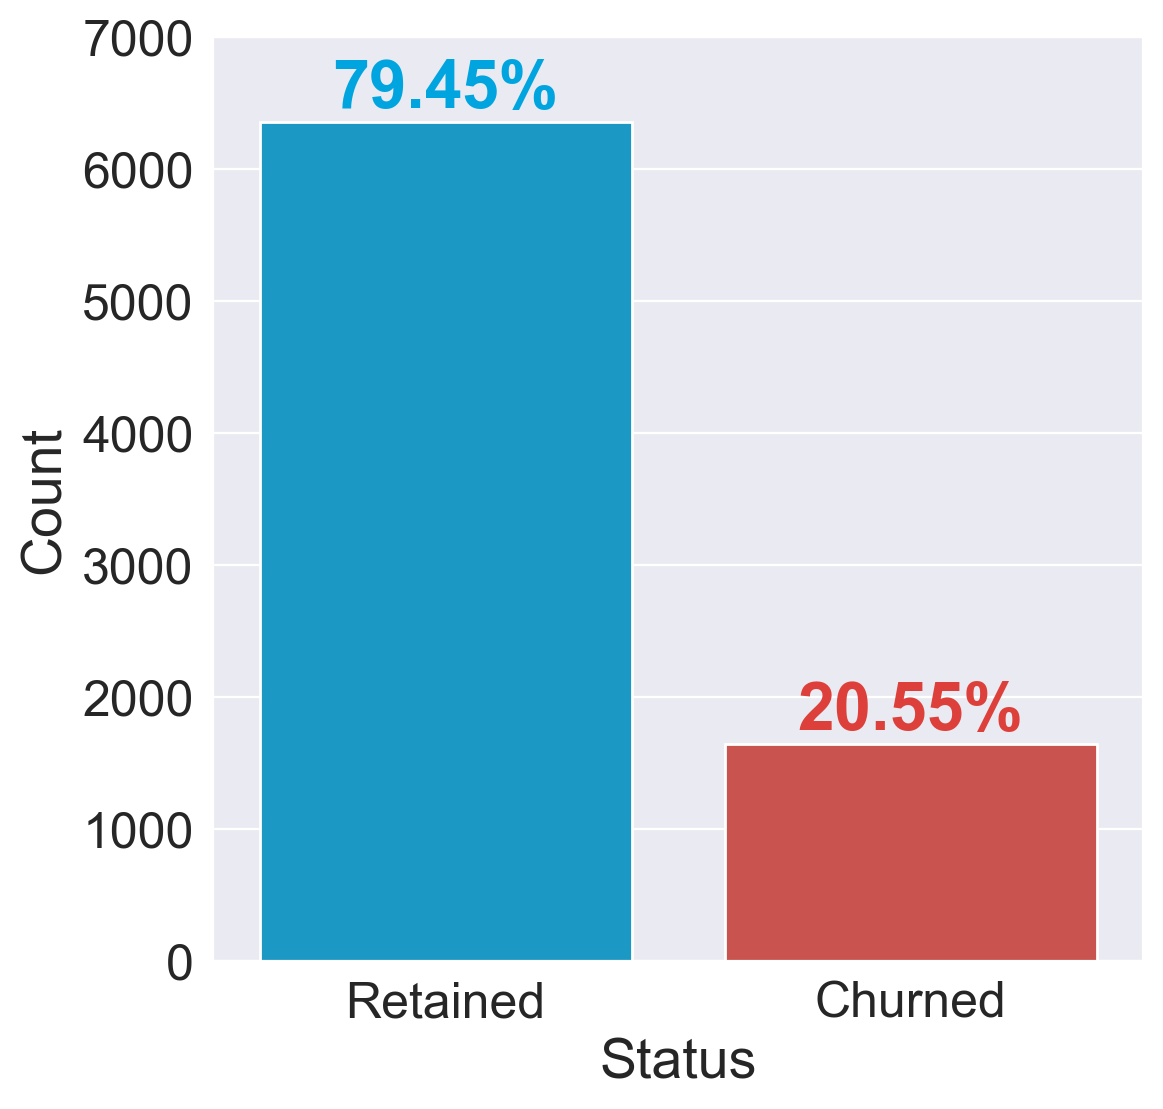

In [172]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

# Önce sabit konumları ayarladık, ardından etiketleri ekledik
ax.set_xticks([0, 1])  # Sabit konumlar (0 ve 1)
ax.set_xticklabels(['Retained', 'Churned'])  # Etiketler

ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000])

plt.show()

Banka, müşterilerinin %80'ini elinde tutmuştur.

Veri setimizin dengesiz(skewed) olduğunu fark edebilirsiniz, çünkü 'Retained' sınıfındaki örneklerin sayısı, 'Churned' sınıfındaki örneklerin sayısından oldukça fazla. Bu nedenle, doğruluk (accuracy) muhtemelen model performansı için en iyi metrik olmayacak.

Farklı görselleştirme teknikleri, farklı türdeki değişkenler için uygulanır, bu nedenle sürekli (continuous) ve kategorik (categorical) değişkenleri ayırmak ve bunları ayrı ayrı incelemek bizim için daha iyi olacak

In [174]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


## Continuous Variables

hist() metodunu çağırarak, dört sürekli sayısal özellik için birer histogram çizebiliriz

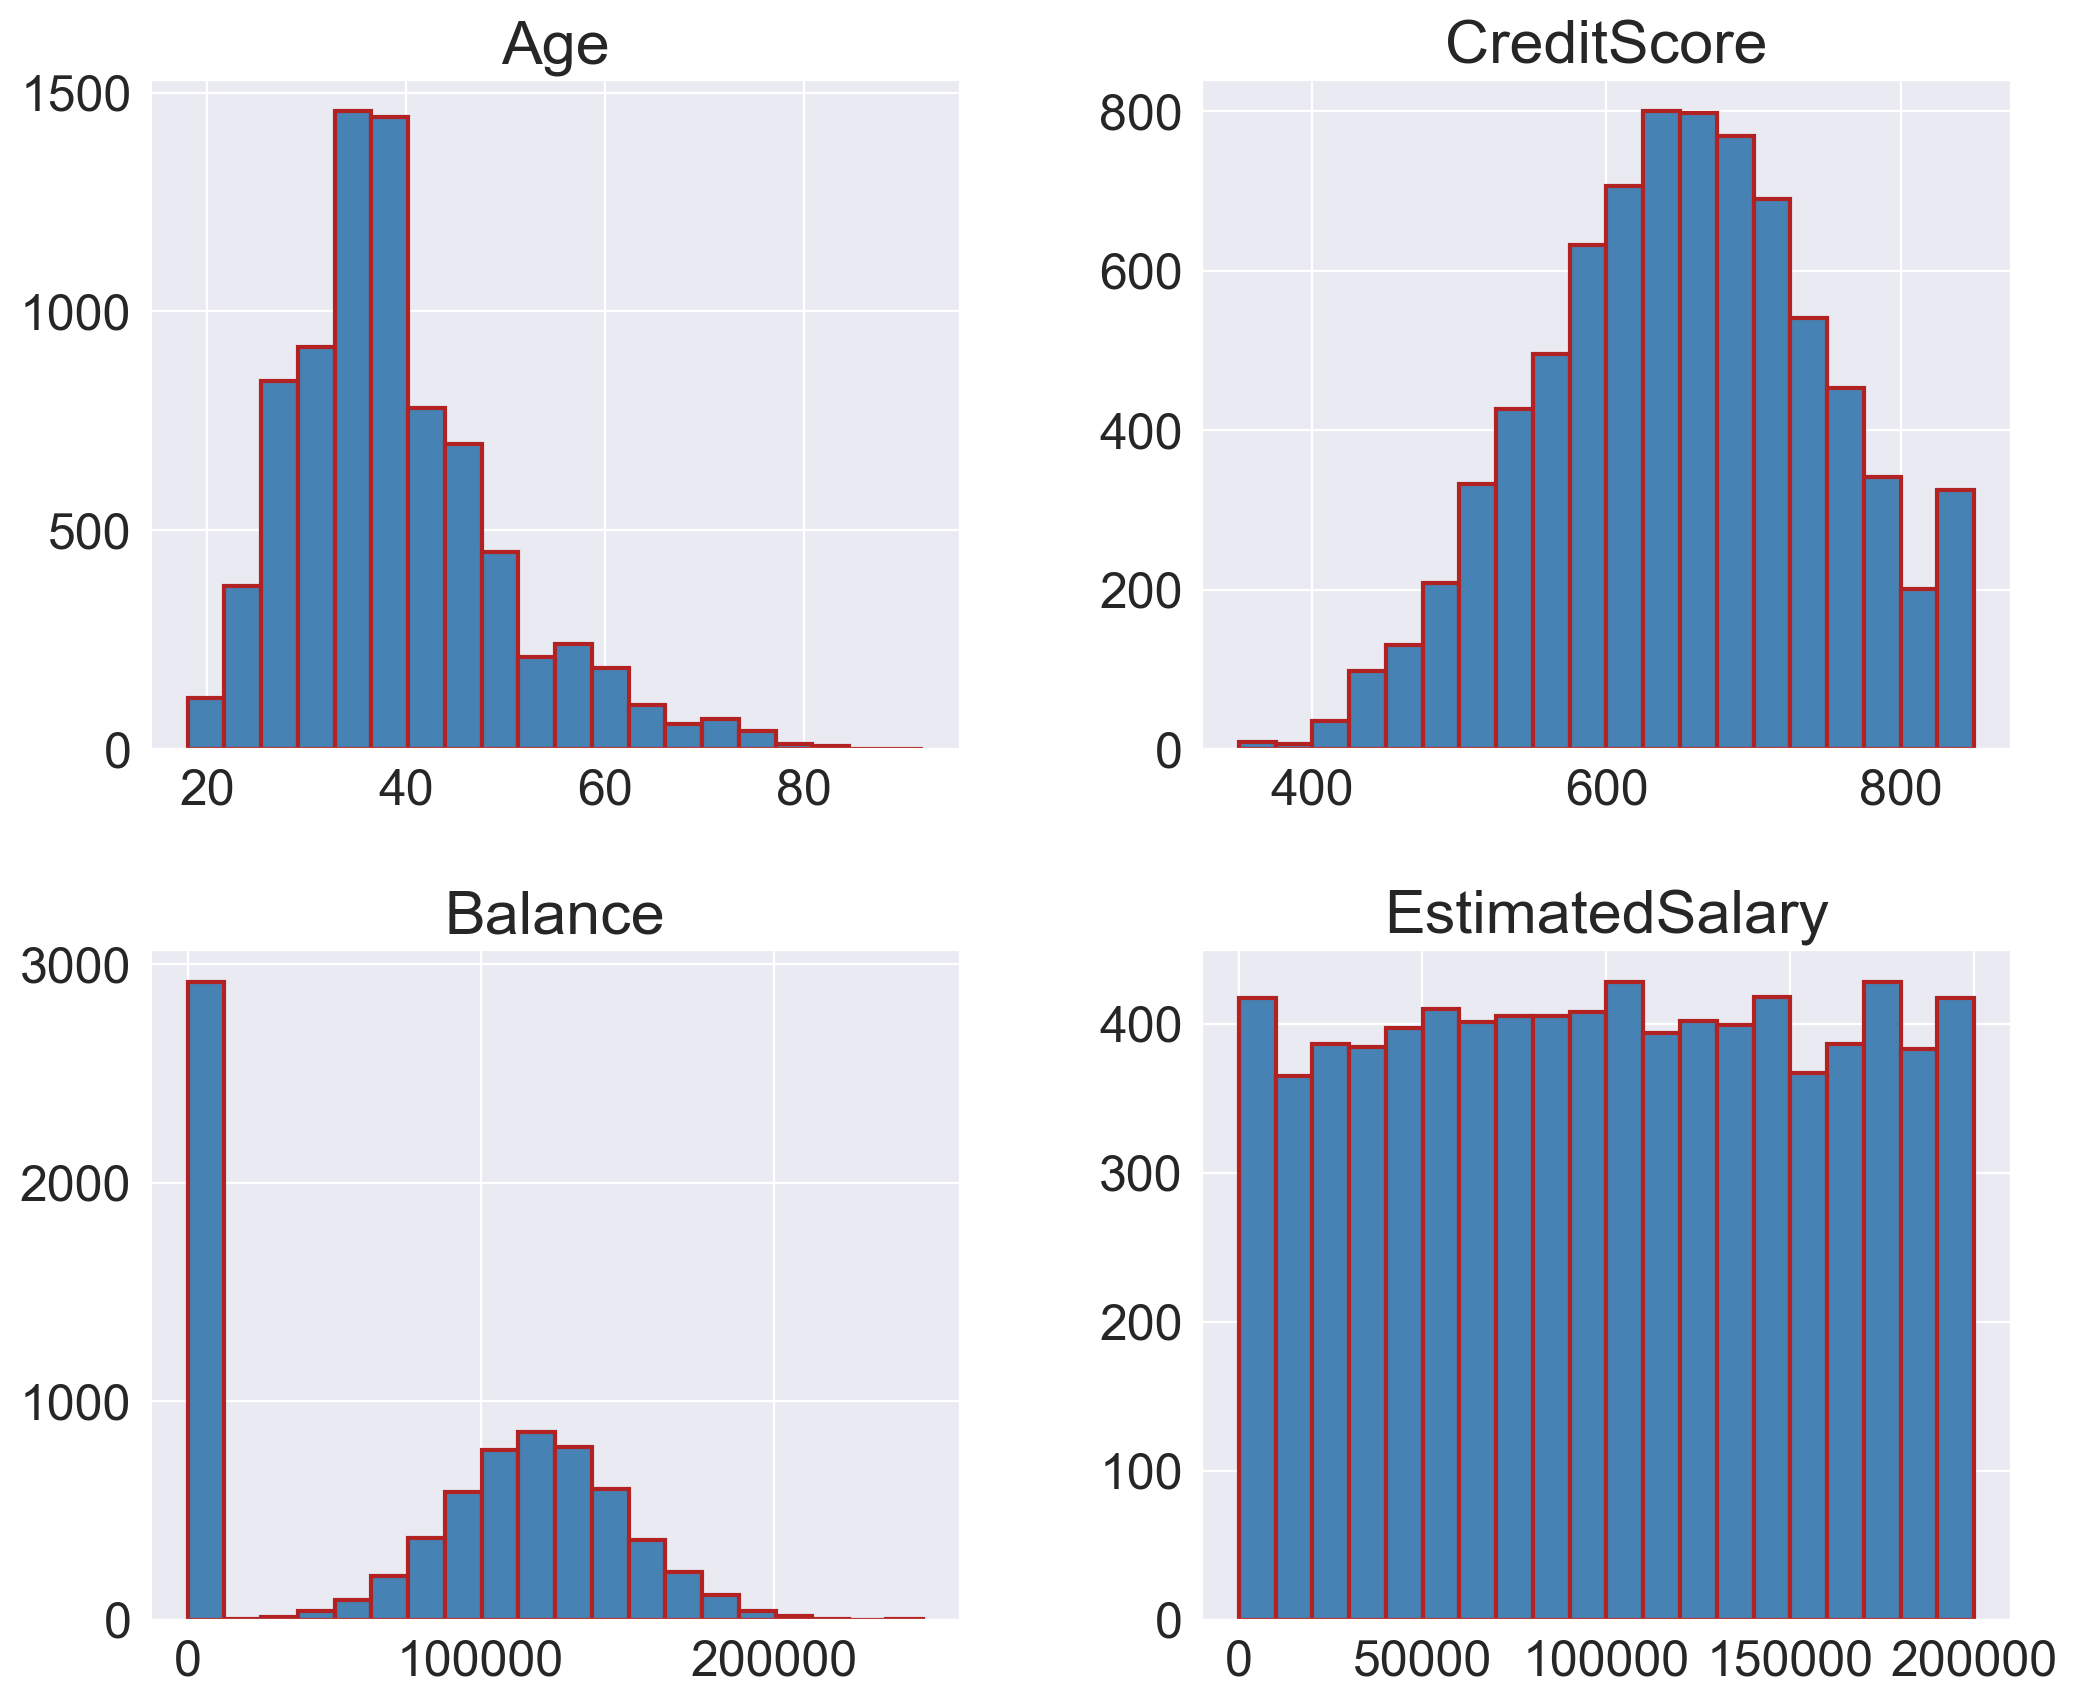

In [177]:
train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

Age (Yaş): Hafifçe sağa doğru kuyruk ağırlığına sahip, yani medyanın sağındaki değerler sola göre daha fazla uzanıyor.
CreditScore (Kredi Puanı): Çoğu değer 600'ün üzerindedir.
Balance (Bakiye): İlk çubuğu (bin) yok sayarsak, bakiye verileri neredeyse normal bir dağılım sergiler.
EstimatedSalary (Tahmini Maaş): Dağılımı daha çok uniformdur(eşit dağılmış) ve fazla bilgi sağlamaz.

## Korelasyonları İnceleme
Sürekli özellikler arasındaki standart korelasyon katsayısını, pandas'ın corr() metodu ile hesaplayabilir ve bir matris olarak görselleştirebiliriz:

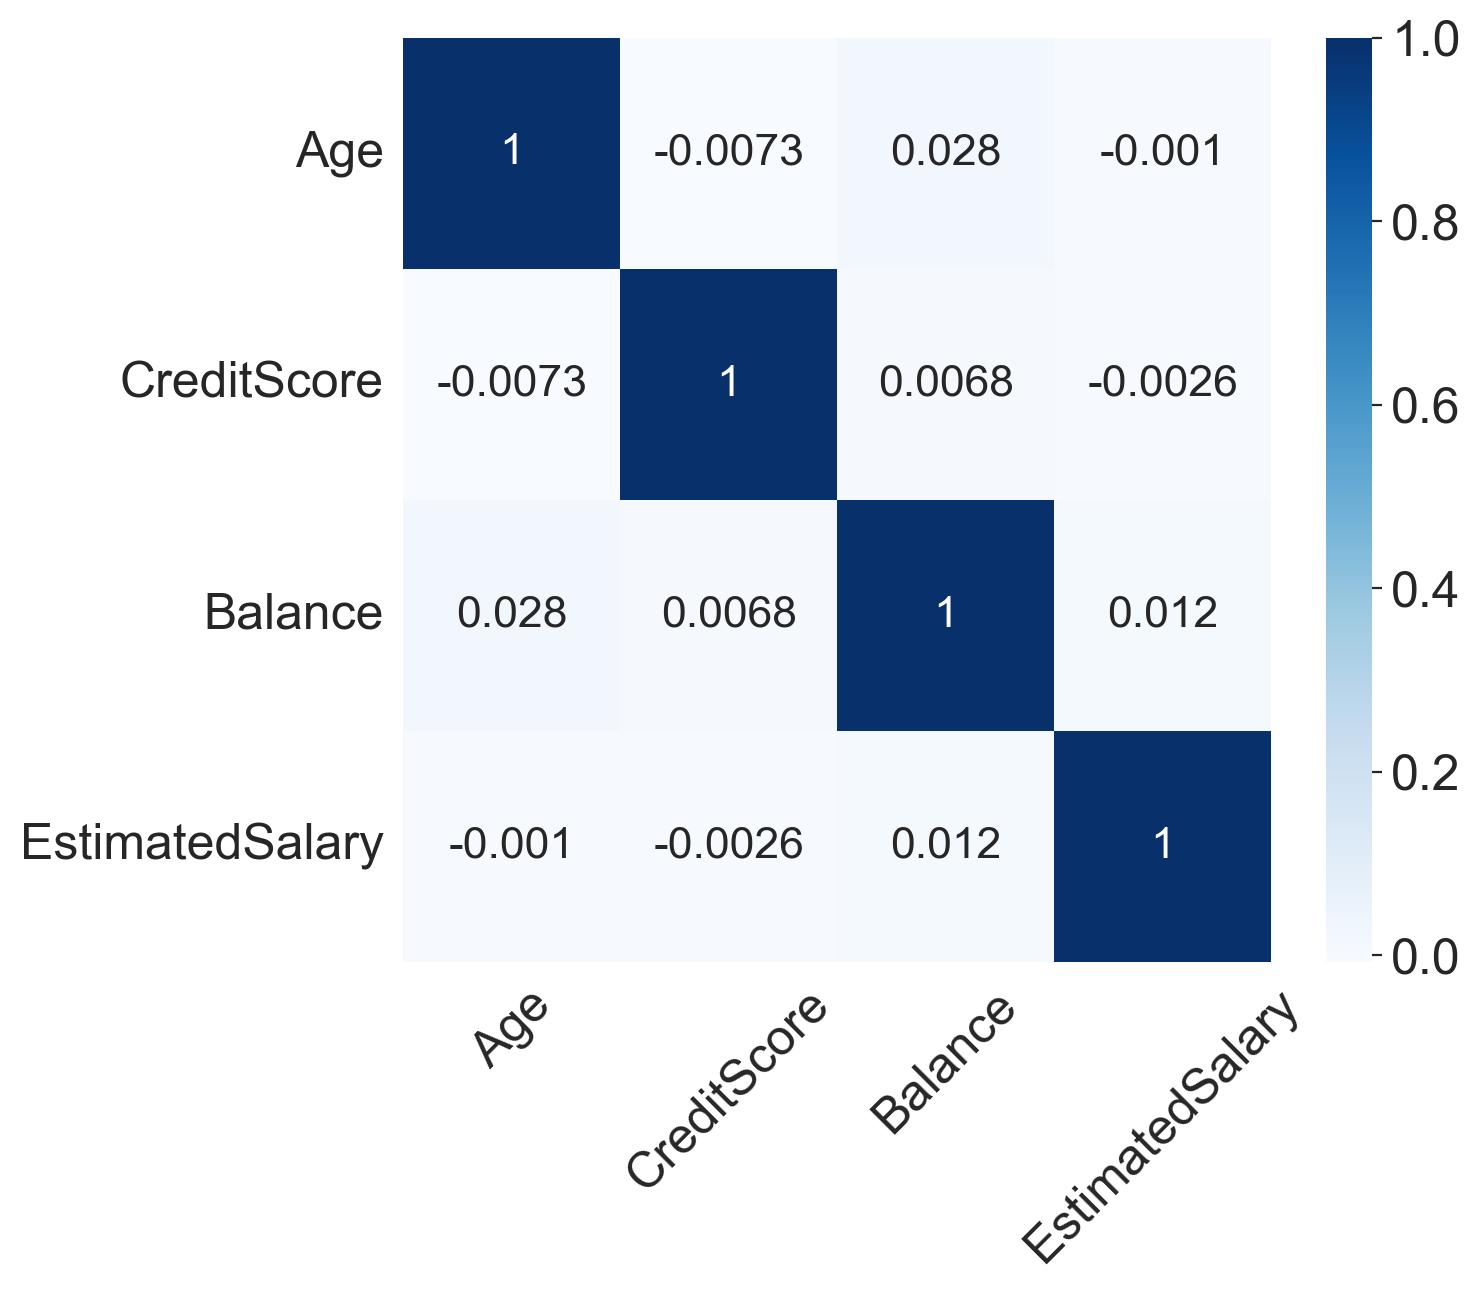

In [180]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

Özelliklerimiz arasında anlamlı bir interkorelasyon bulunmamaktadır, bu nedenle çoklu doğrusal bağlantı (multicollinearity) konusunda endişelenmemize gerek yok.

Şimdi bu özellikleri daha ayrıntılı bir şekilde inceleyelim.

### Age

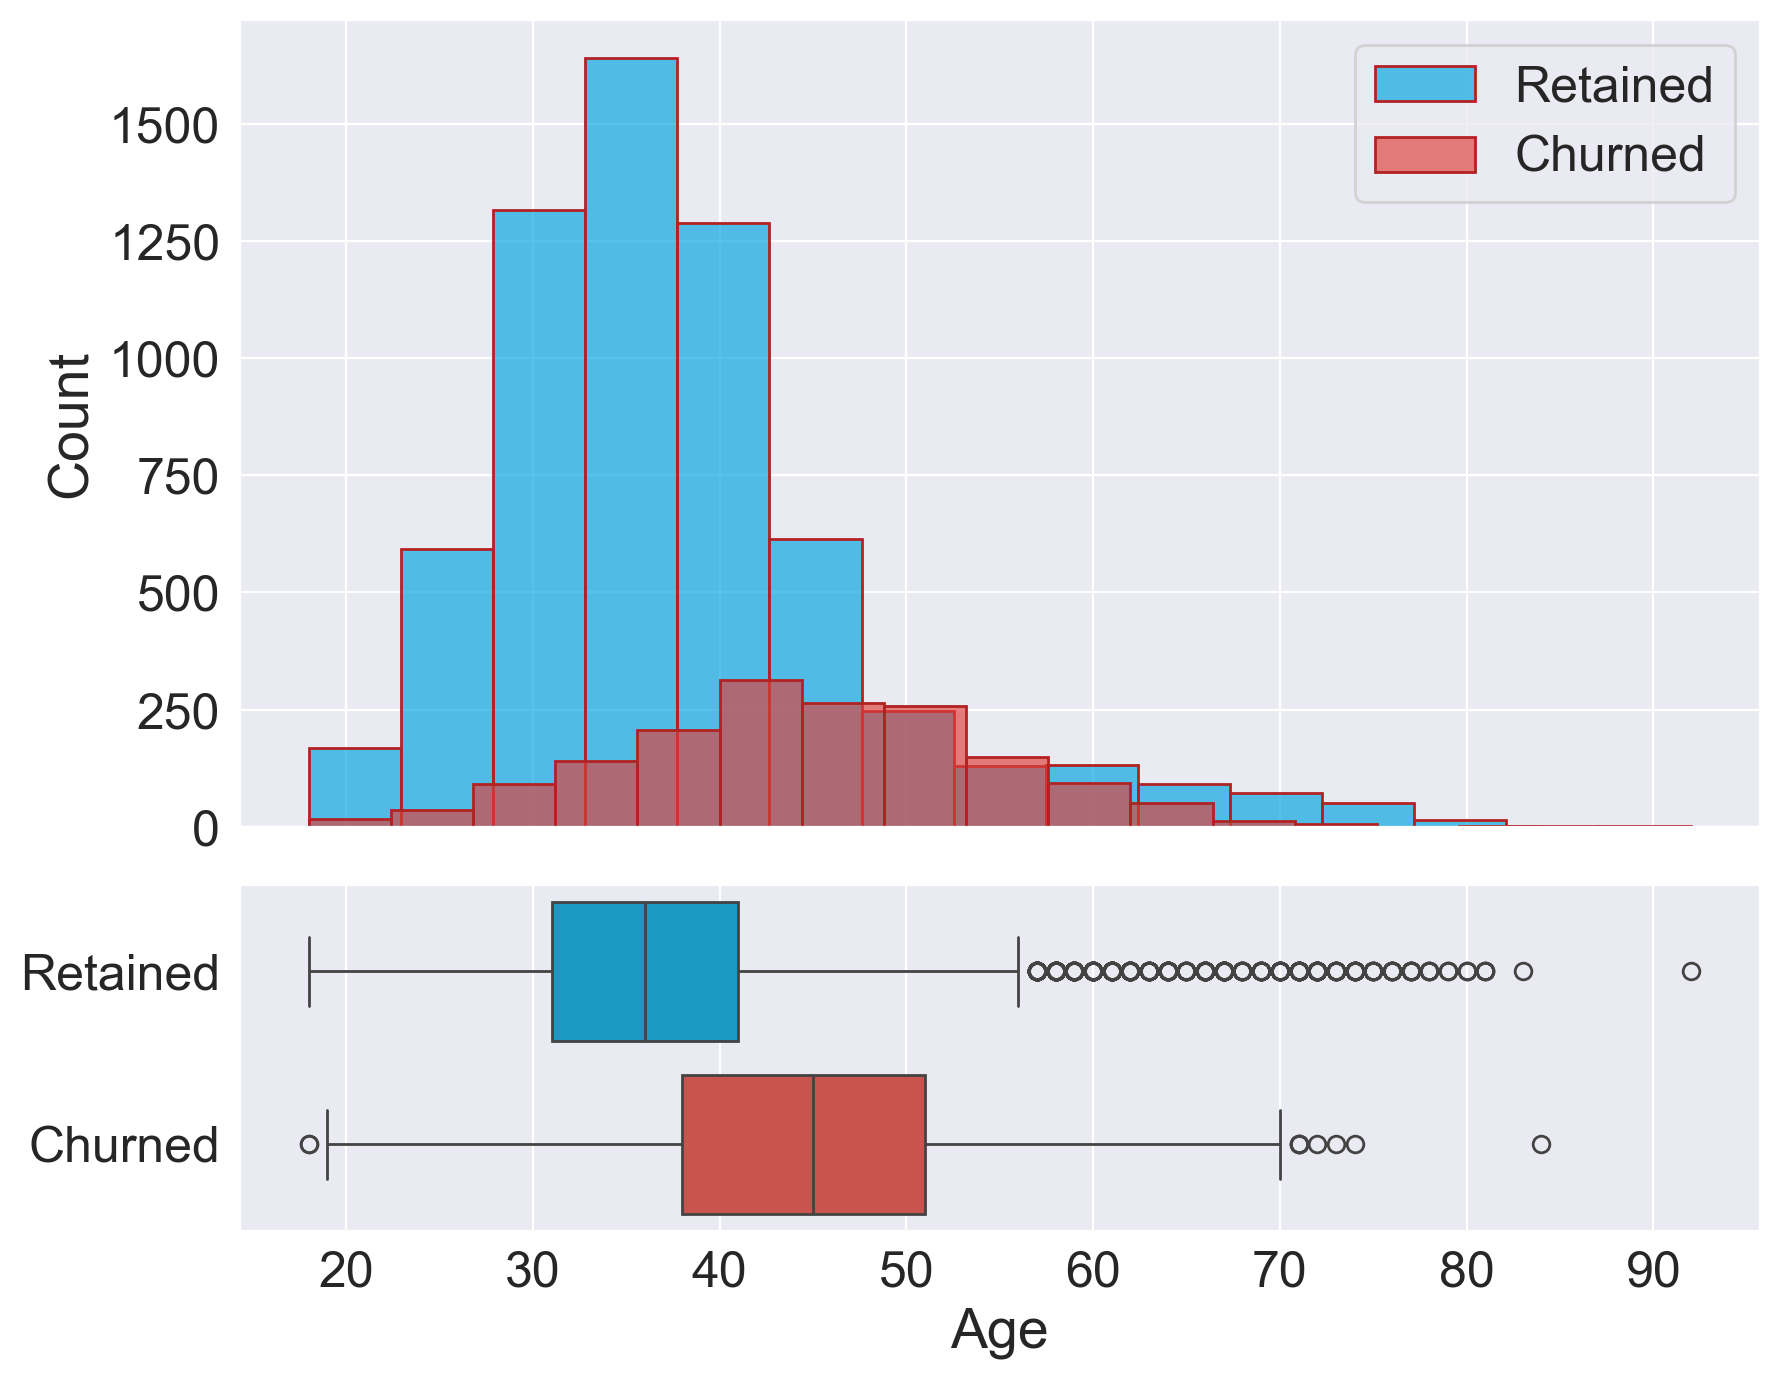

In [183]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

Gördüğümüz üzere yaş grupları arasında belirgin bir fark vardır; daha yaşlı müşterilerin hizmetten ayrılma olasılığı daha yüksek. Bu, yaşla birlikte tercihlerin değişebileceğini ve bankanın, daha yaşlı müşterilerin ihtiyaçlarını karşılayacak şekilde stratejisini uyarlamamış olabileceğini gösterebilir.

### Credit Score

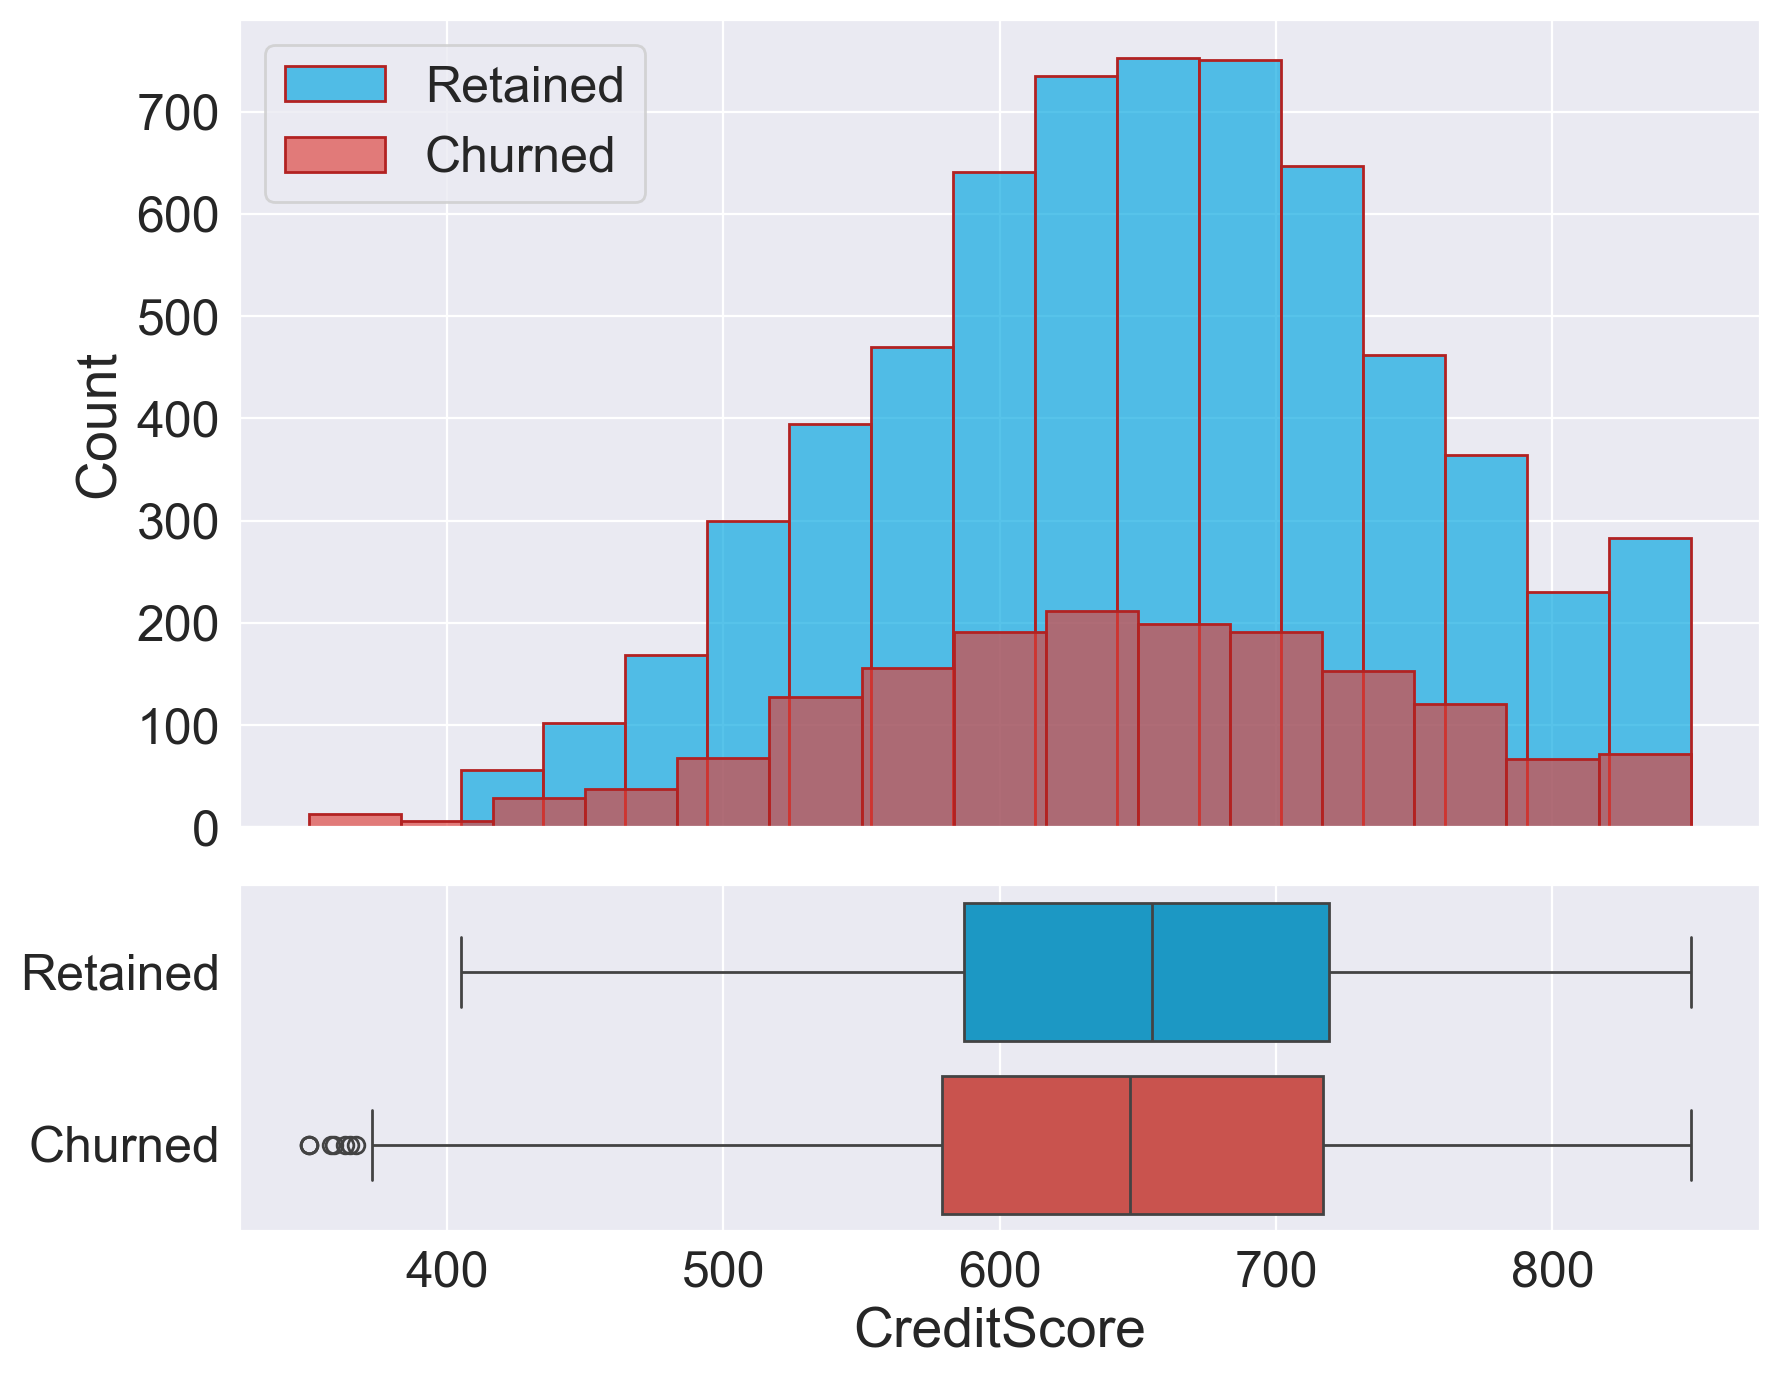

In [186]:
plot_continuous('CreditScore')

Müşterilerin kredi puanları açısından, hizmette kalan (retained) ve ayrılan (churned) müşteriler arasında belirgin bir fark bulunmamaktadır.

### Balance

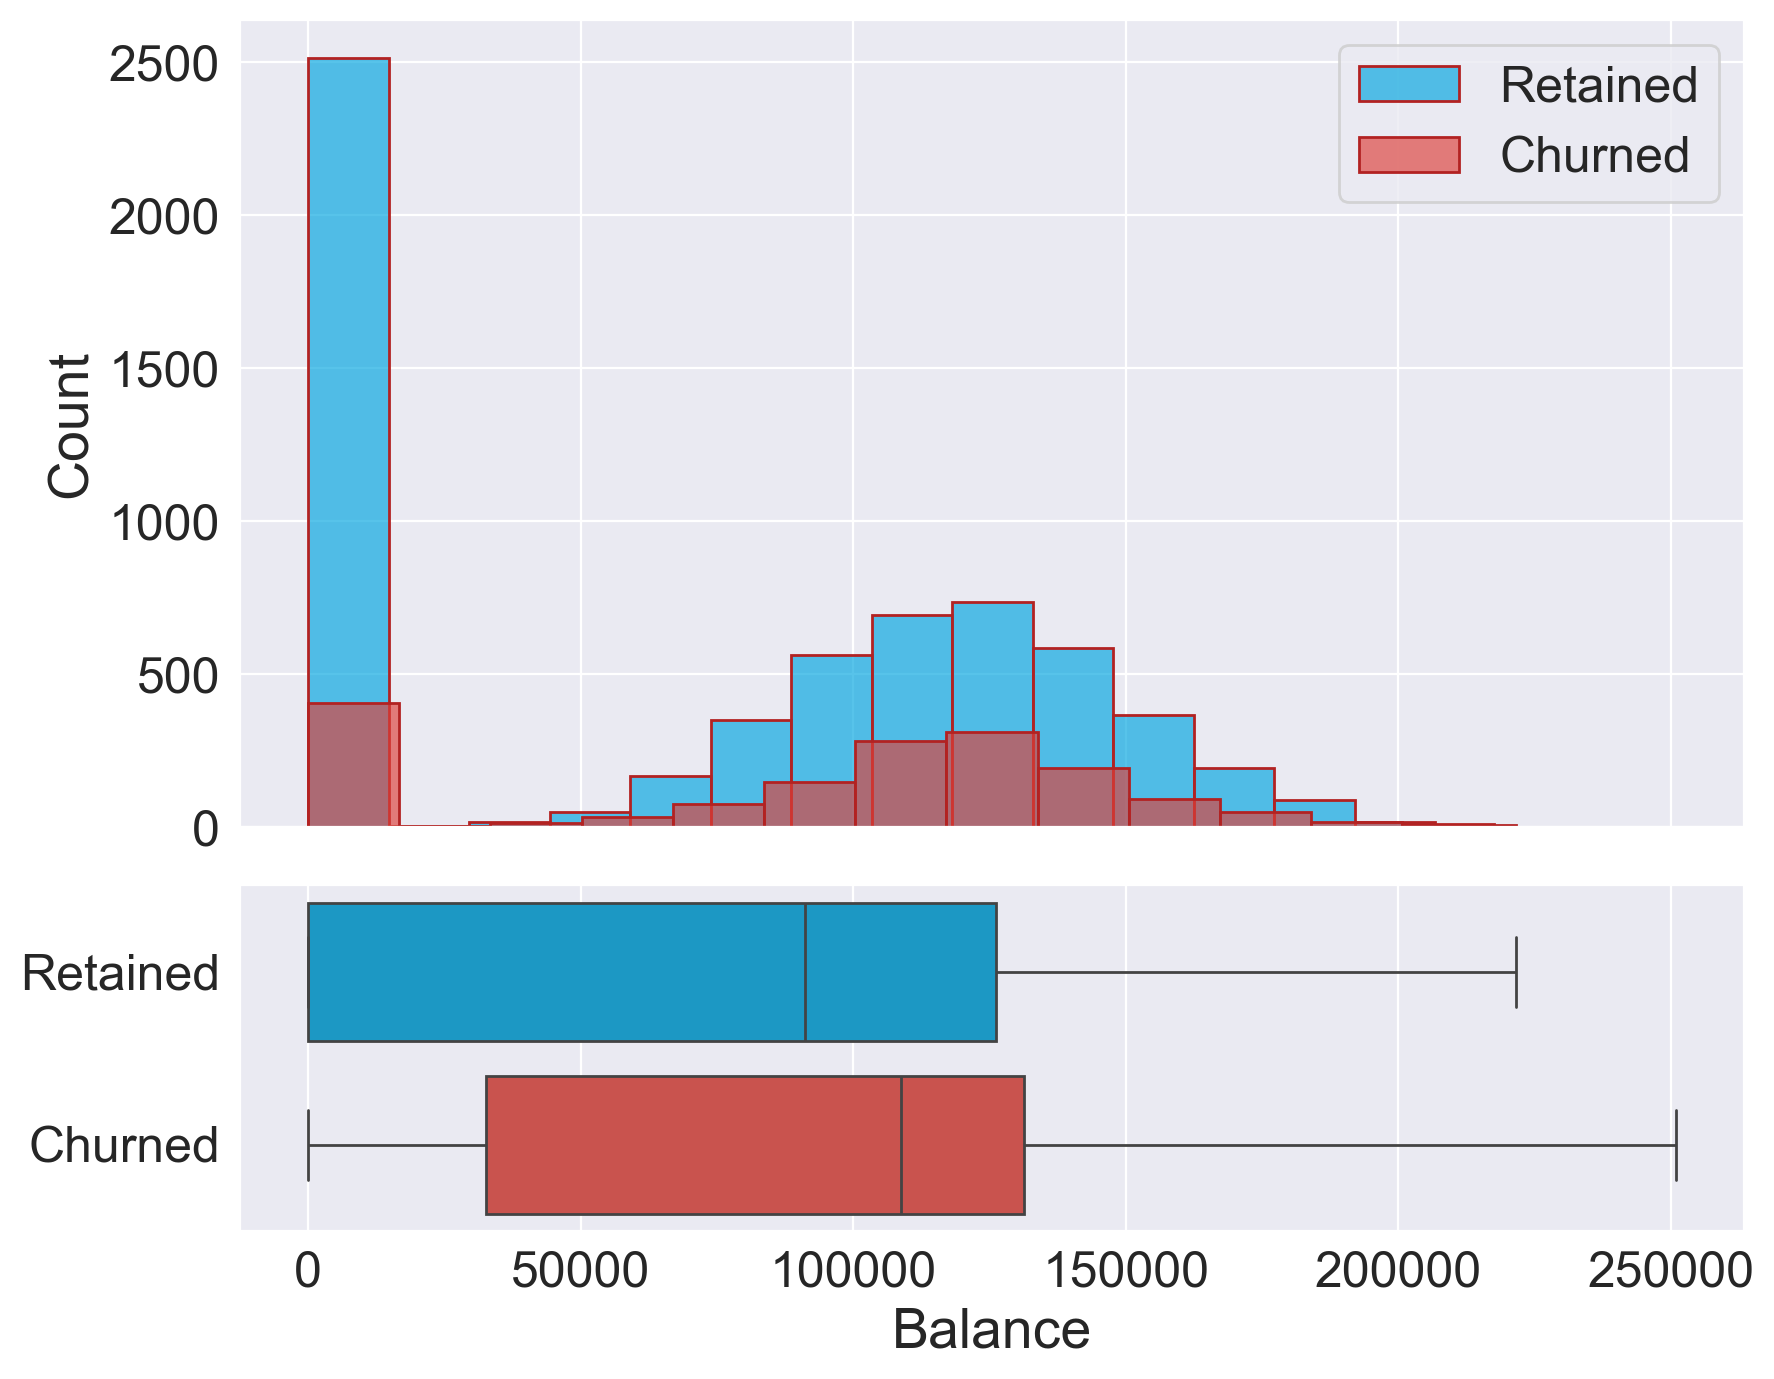

In [189]:
plot_continuous('Balance')

Yine, iki dağılım oldukça benzerdir. Ancak, düşük hesap bakiyesine sahip müşteriler arasında büyük bir oran, hizmetten ayrılmayan (non-churned) müşterilere aittir.

### Estimated Salary

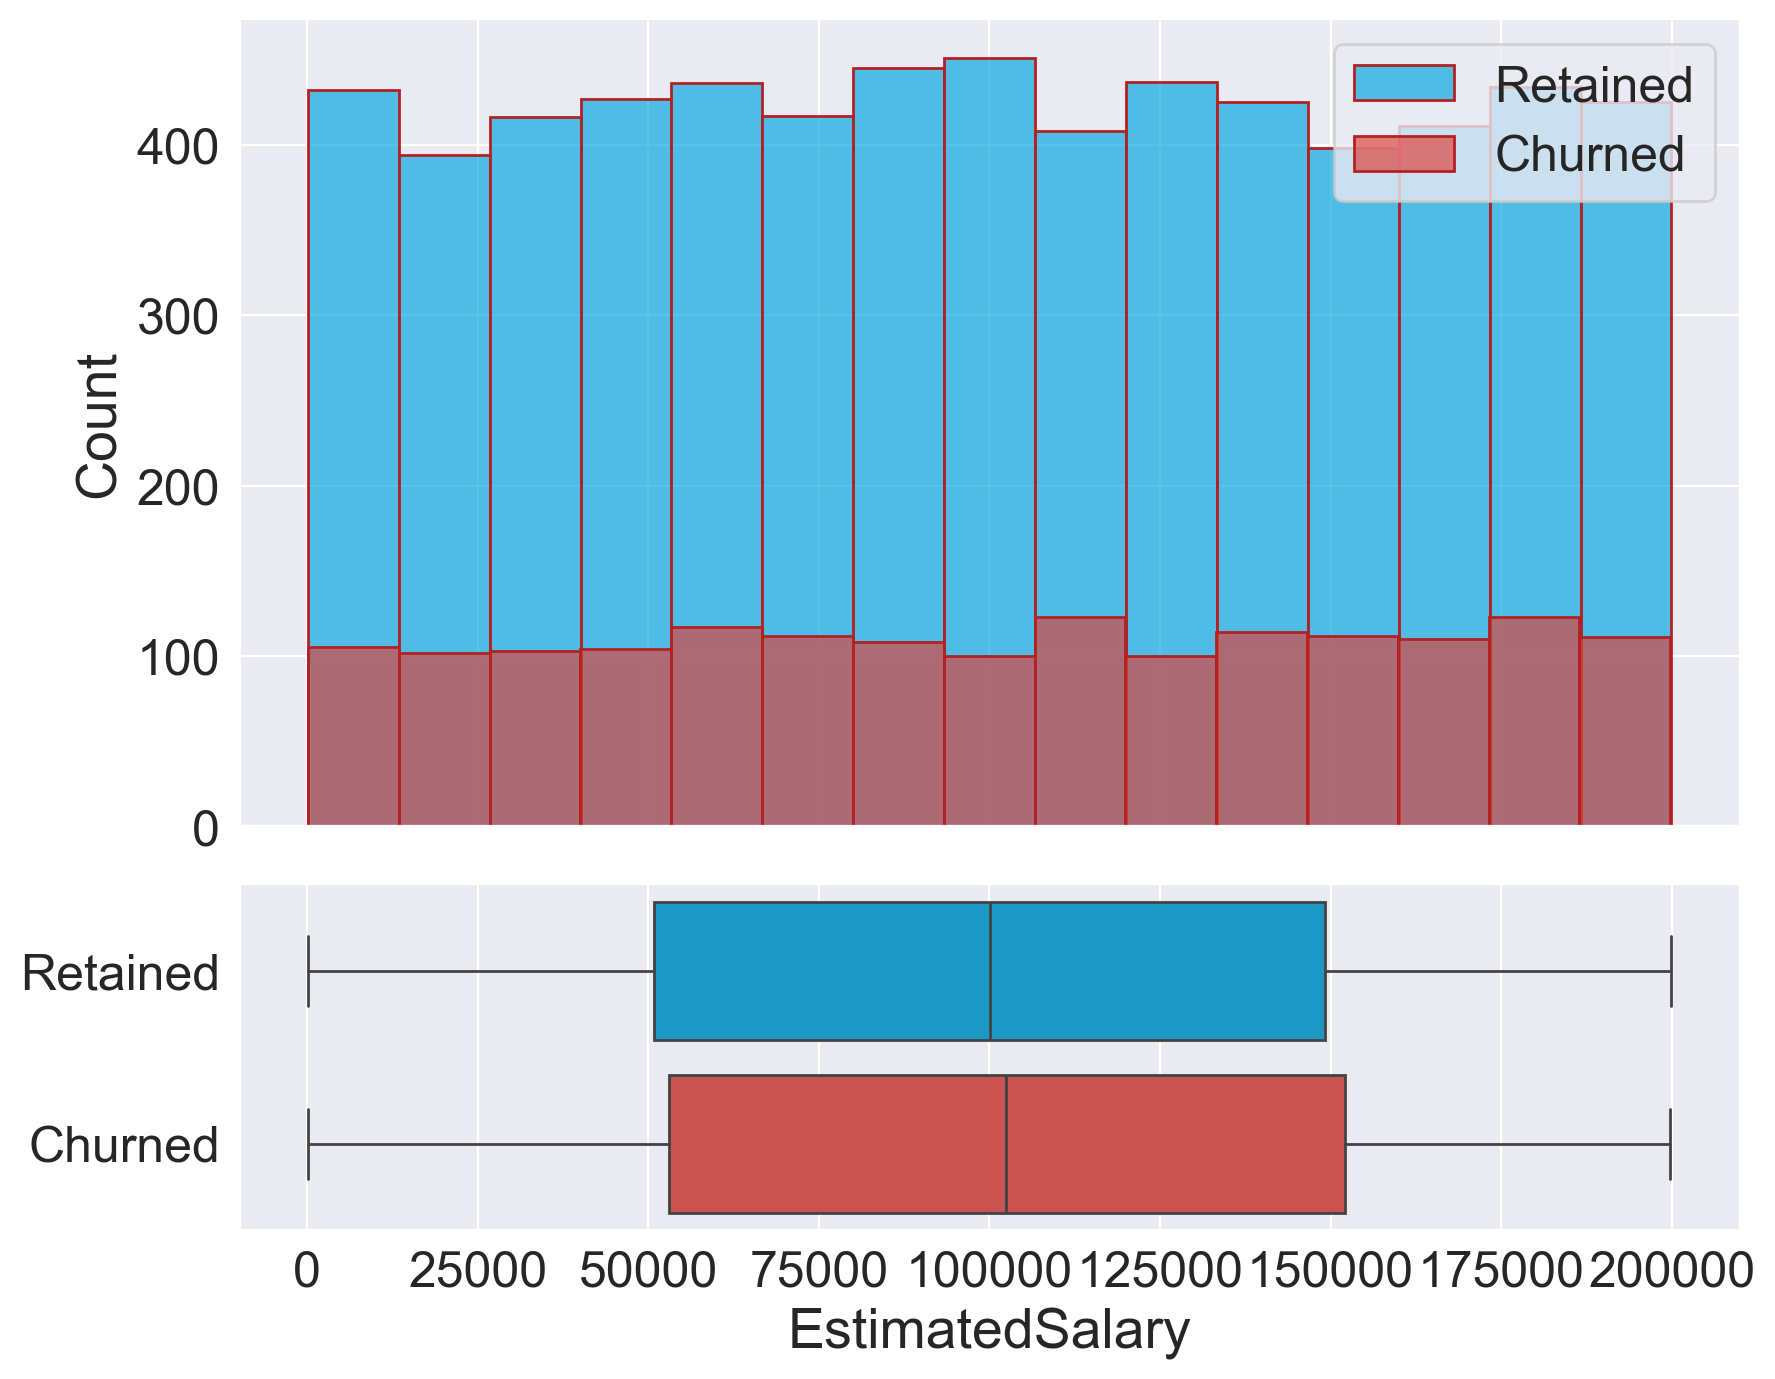

In [192]:
plot_continuous('EstimatedSalary')

Hem hizmetten ayrılan (churned) hem de kalan (retained) müşterilerin maaşlarında benzer bir uniform dağılım var. Sonuç olarak, maaşın hizmetten ayrılma olasılığı üzerinde önemli bir etkisi olmadığı sonucuna varabiliriz.

## Categorical Variables

Kategorik değişkenlerin her biri için bir seaborn.countplot çizerek dağılımlarını görselleştirebiliriz.

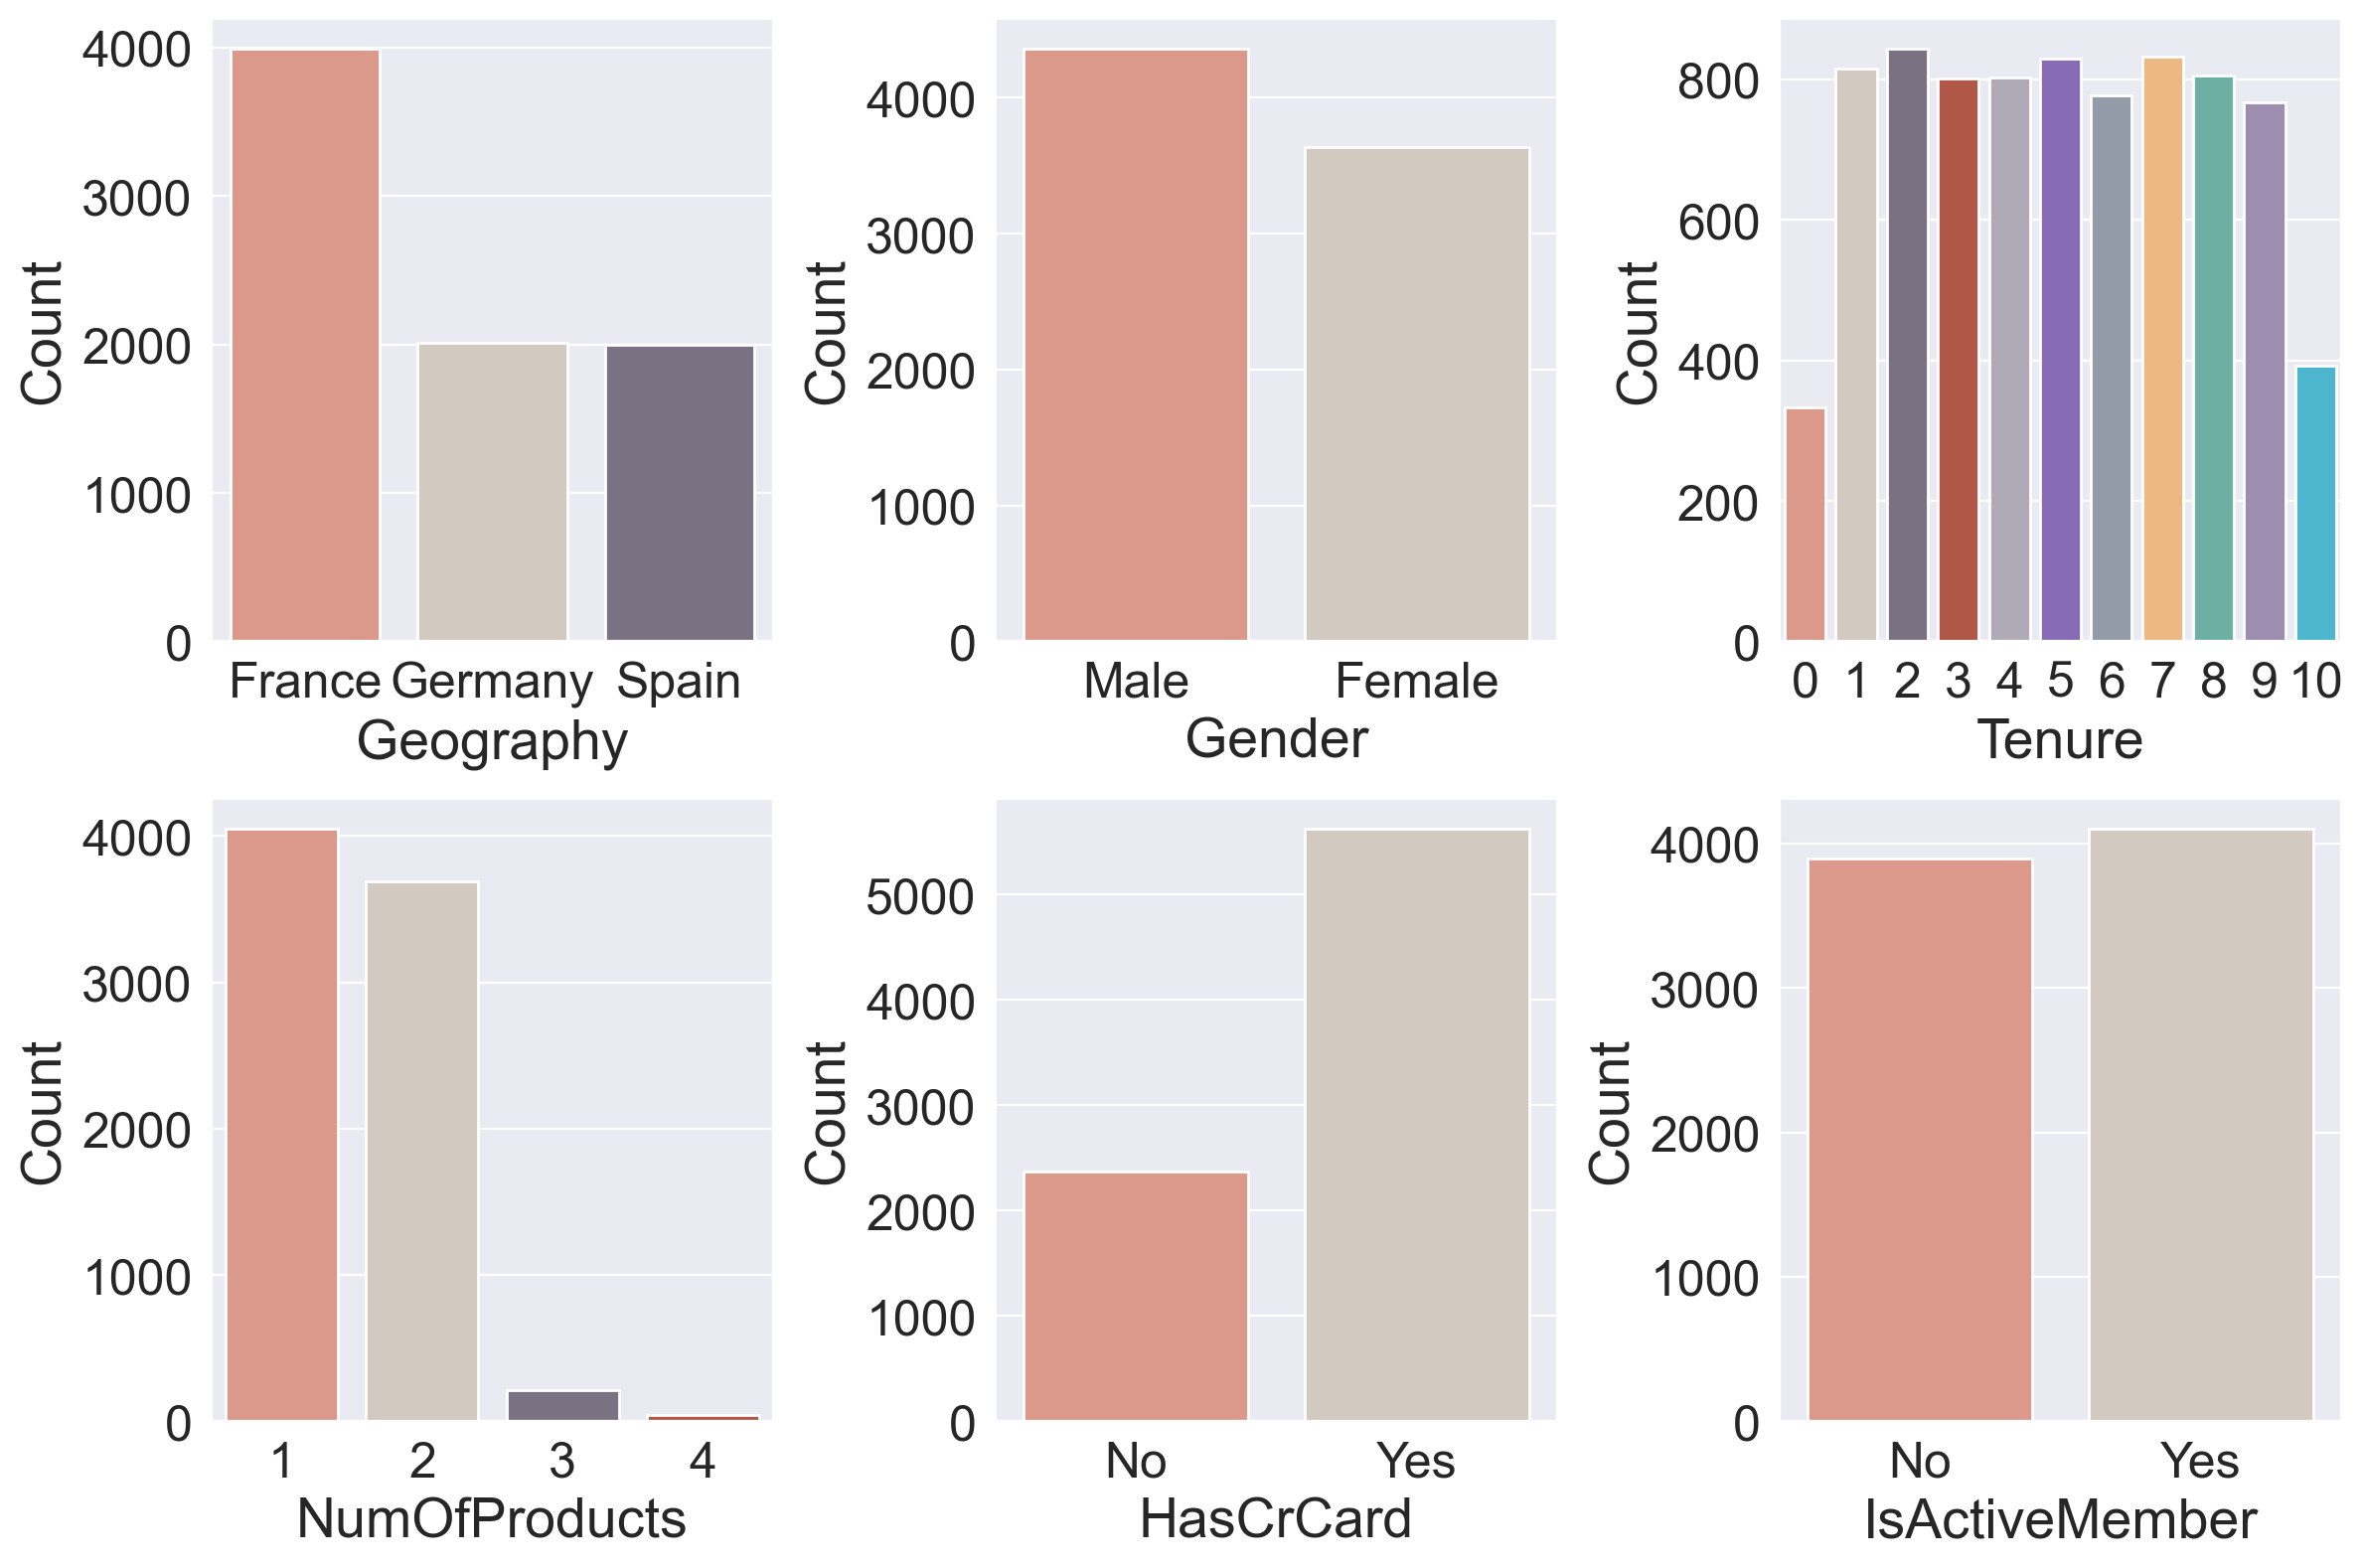

In [196]:
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

Önemli Noktalar:
* Bankanın müşterileri üç ülkede bulunmaktadır (Fransa, İspanya ve Almanya). Müşterilerin çoğunluğu Fransa'dadır.
* Erkek müşterilerin sayısı kadınlardan daha fazladır.
* Küçük bir yüzde, ilk yıl içinde bankadan ayrılmaktadır. 1 ila 9 yıl arasında bağlılık süresine sahip müşterilerin sayısı neredeyse aynıdır.
* Müşterilerin çoğu 1 veya 2 ürün satın almışken, küçük bir kısmı 3 veya 4 ürün satın almıştır.
* Müşterilerin büyük bir çoğunluğu kredi kartına sahiptir.
* Müşterilerin yaklaşık %50'si aktif değildir.  
Bu özelliklere tekrar daha ayrıntılı bir şekilde bakmamız gerekecek.

### Geography

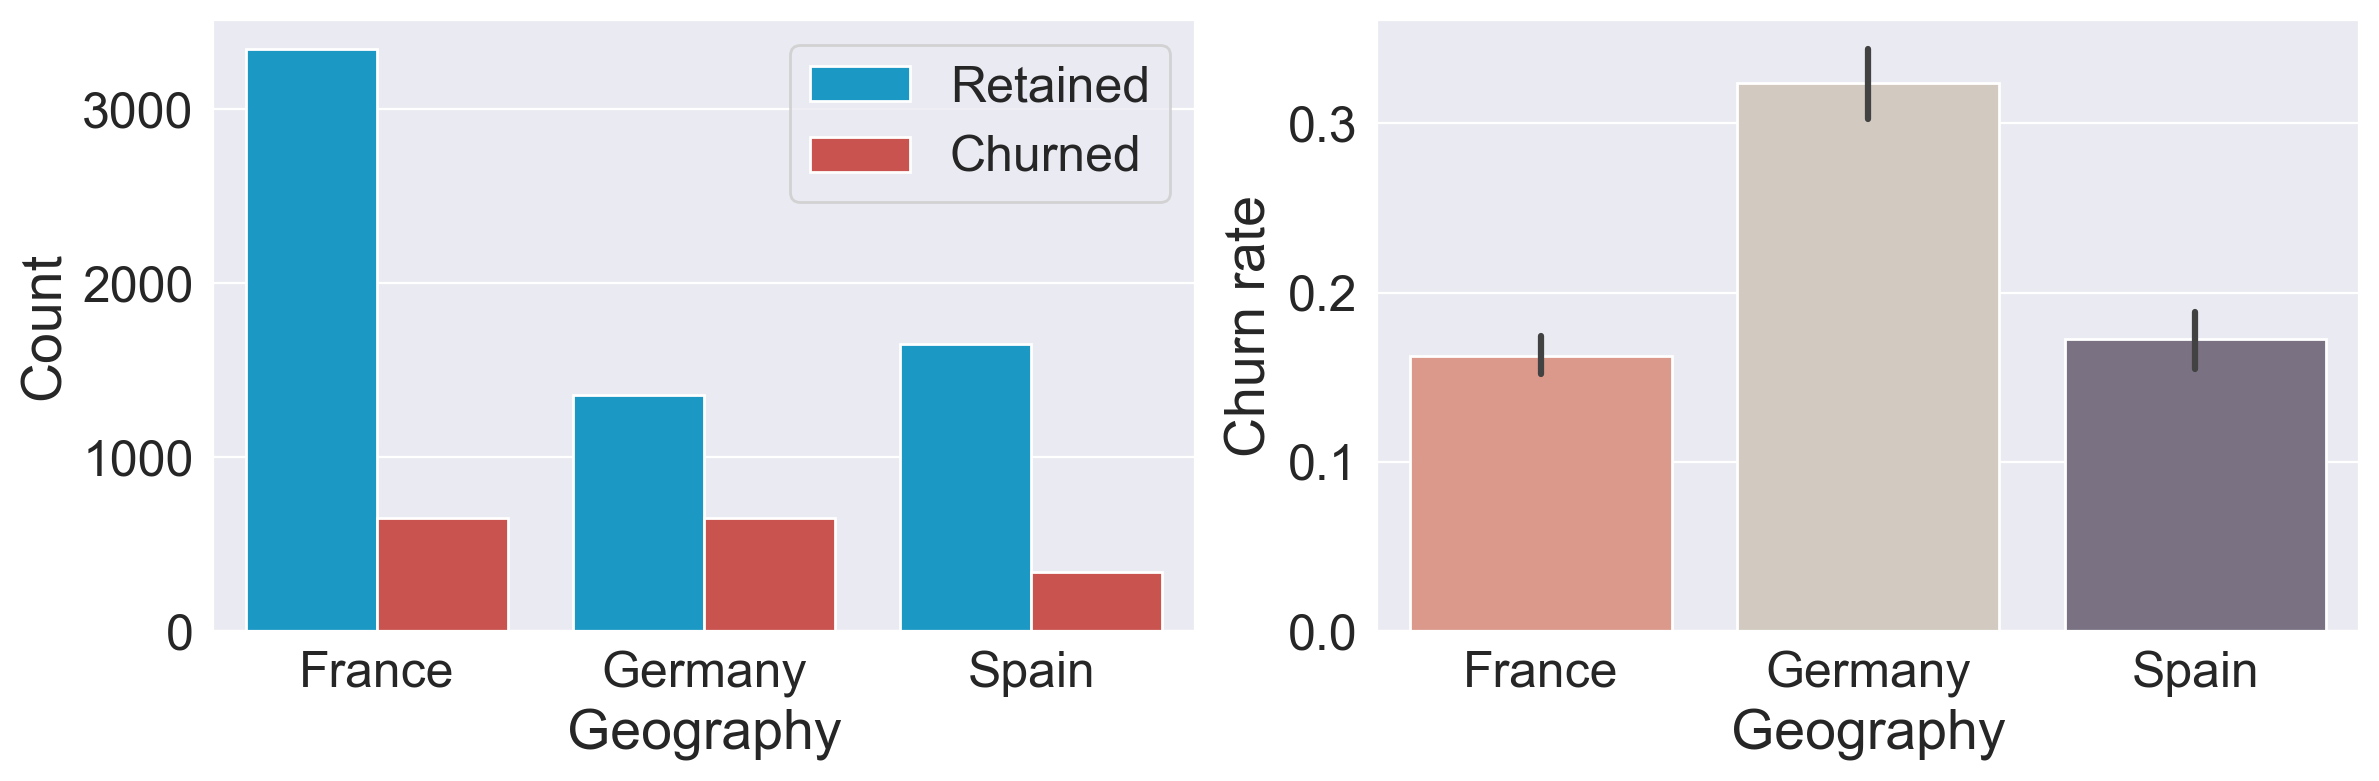

In [199]:
plot_categorical('Geography')

Almanya'daki müşterilerin hizmetten ayrılma olasılığı, İspanya ve Fransa'ya göre daha yüksektir. Hizmetten ayrılma oranı neredeyse iki kat fazladır. Bu durumu, daha yüksek rekabet veya Alman müşterilerinin farklı tercihlerinin olması gibi birçok neden açıklayabilir.








### Gender

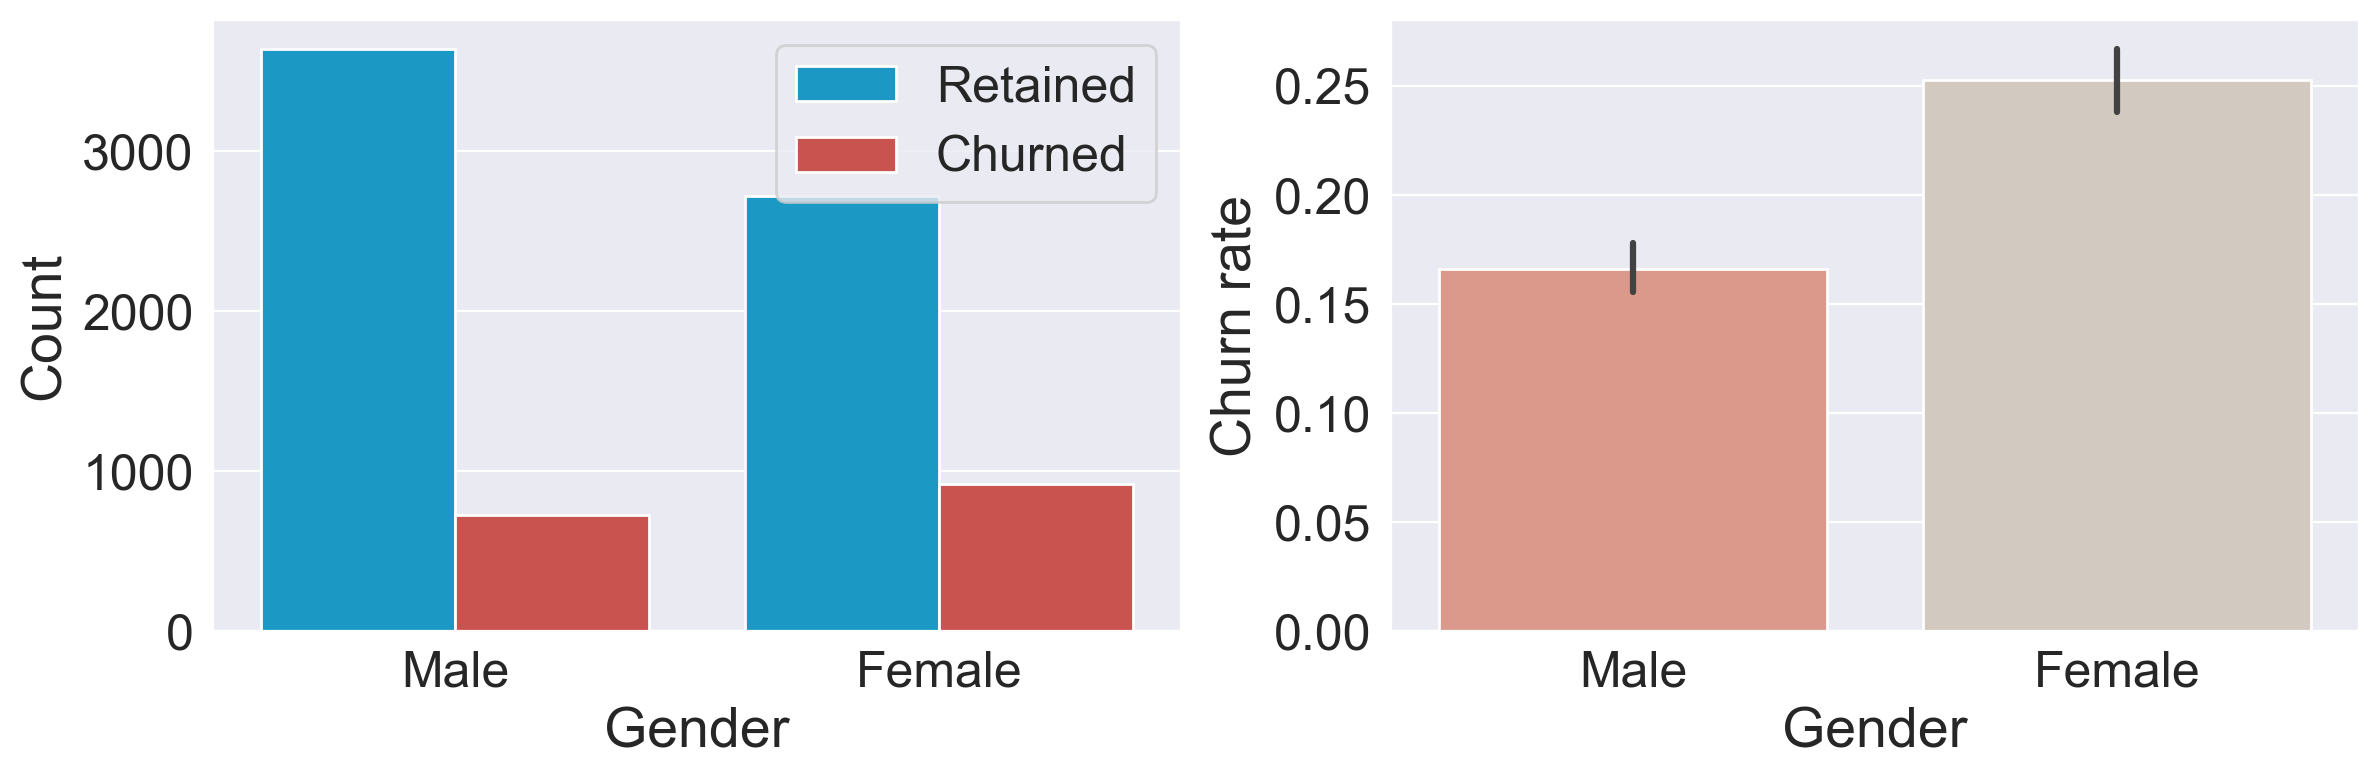

In [202]:
plot_categorical('Gender')

Kadın müşterilerin ayrılmaya daha yatkın olduğunu görüyoruz.

### Tenure

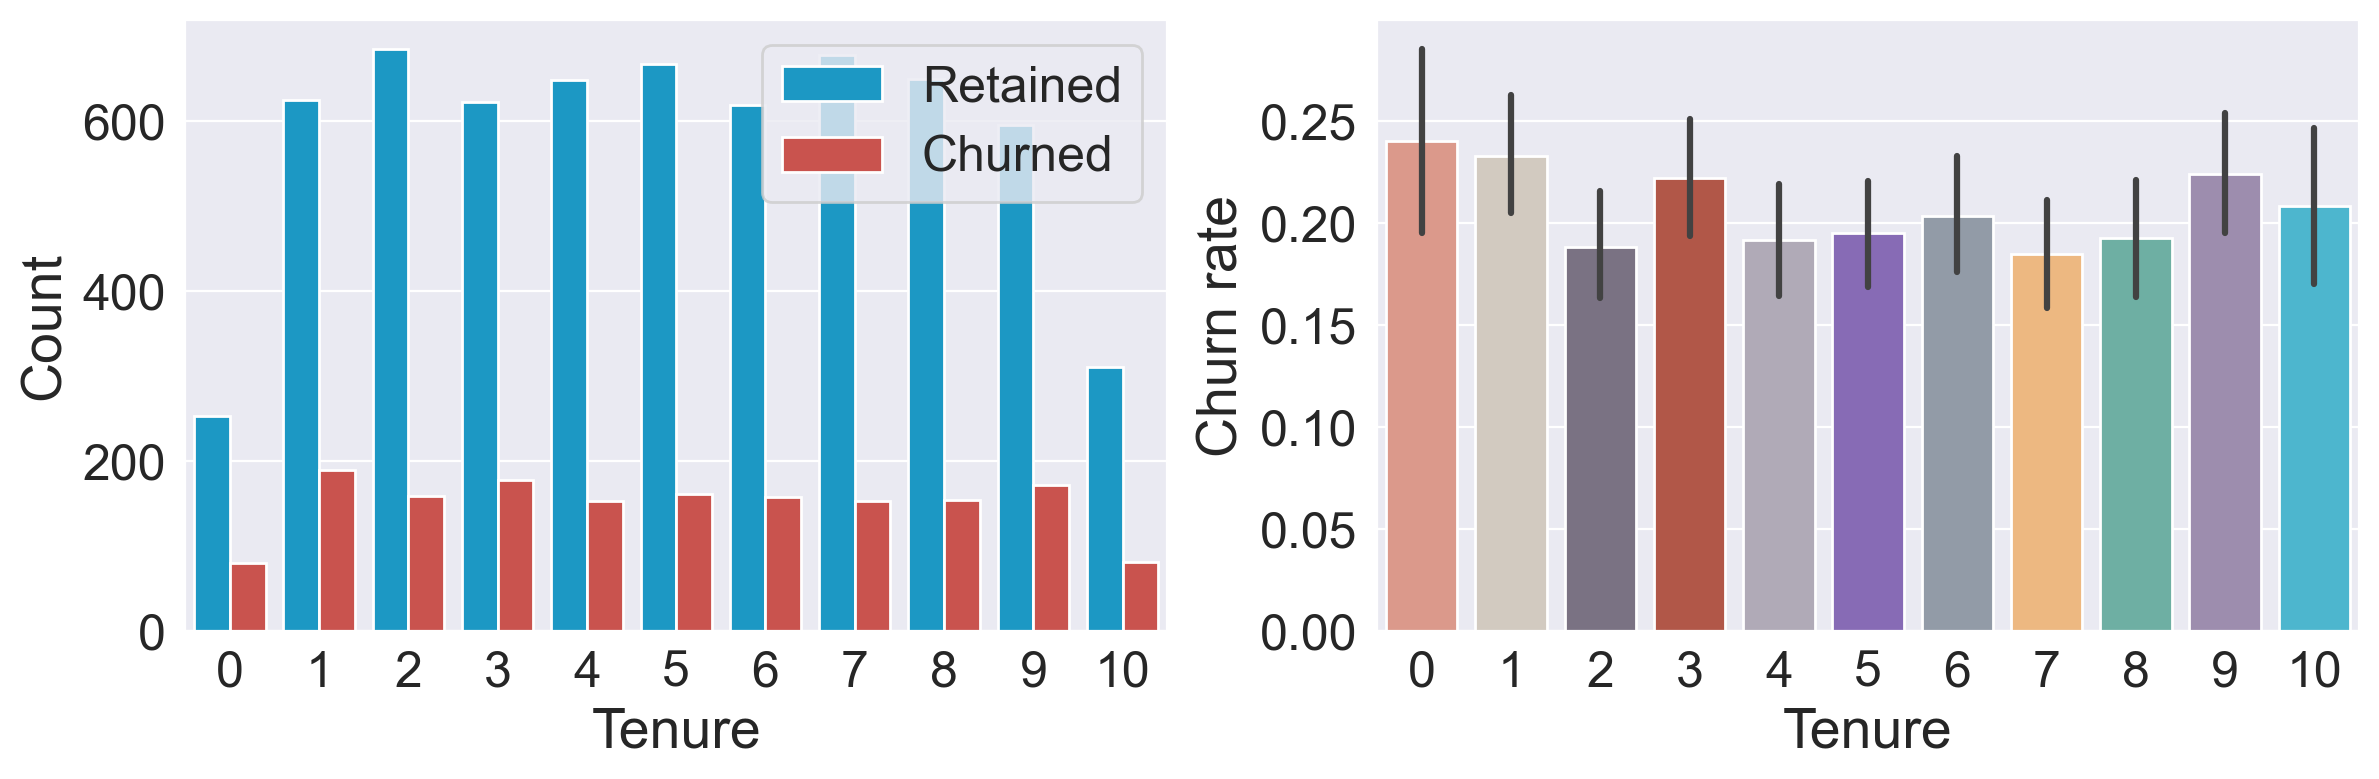

In [205]:
plot_categorical('Tenure')

Müşteri bağlılık süresi (tenure) hizmetten ayrılma oranını etkilemiyor gibi görünüyor.

### Number of Products

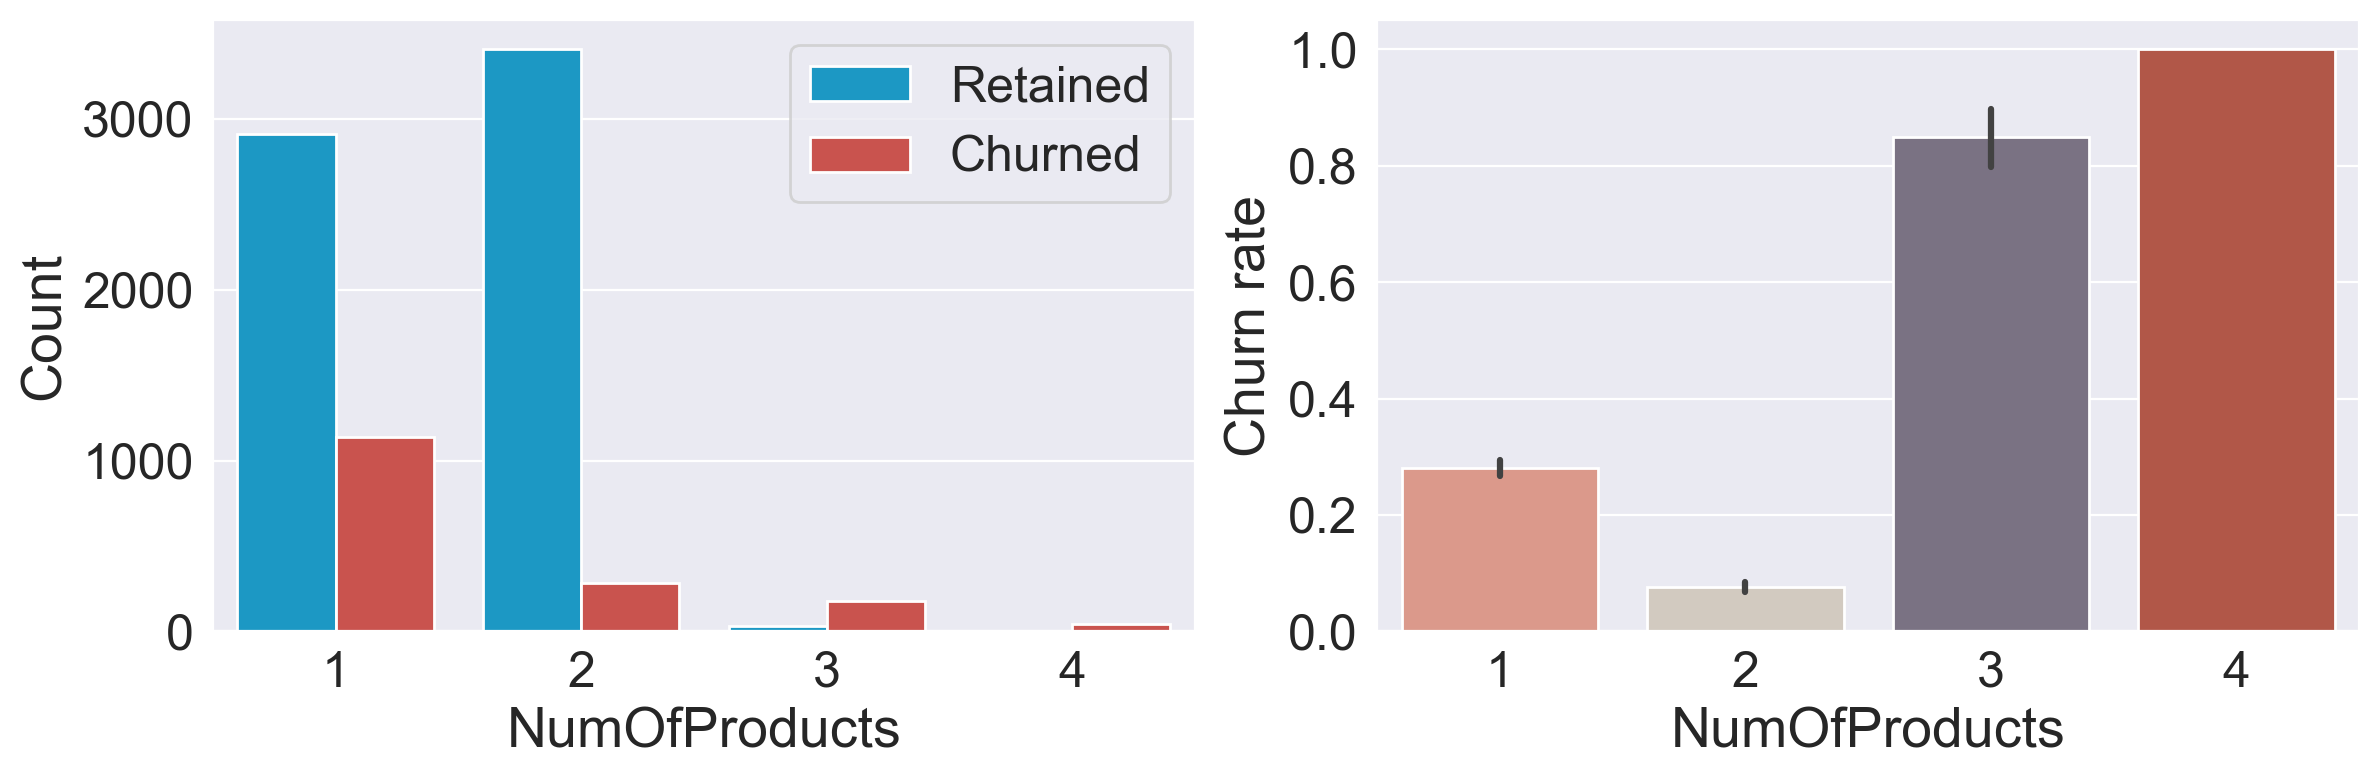

In [208]:
plot_categorical('NumOfProducts')

İlginç bir şekilde, 3 veya 4 ürüne sahip olmak hizmetten ayrılma olasılığını önemli ölçüde artırmaktadır. Bu sonucu nasıl yorumlayacağım konusunda emin değilim. Bu durum, bankanın daha fazla ürüne sahip müşterileri düzgün bir şekilde destekleyemediği ve bunun da müşteri memnuniyetsizliğini artırdığı anlamına gelebilir.

### Card Holders

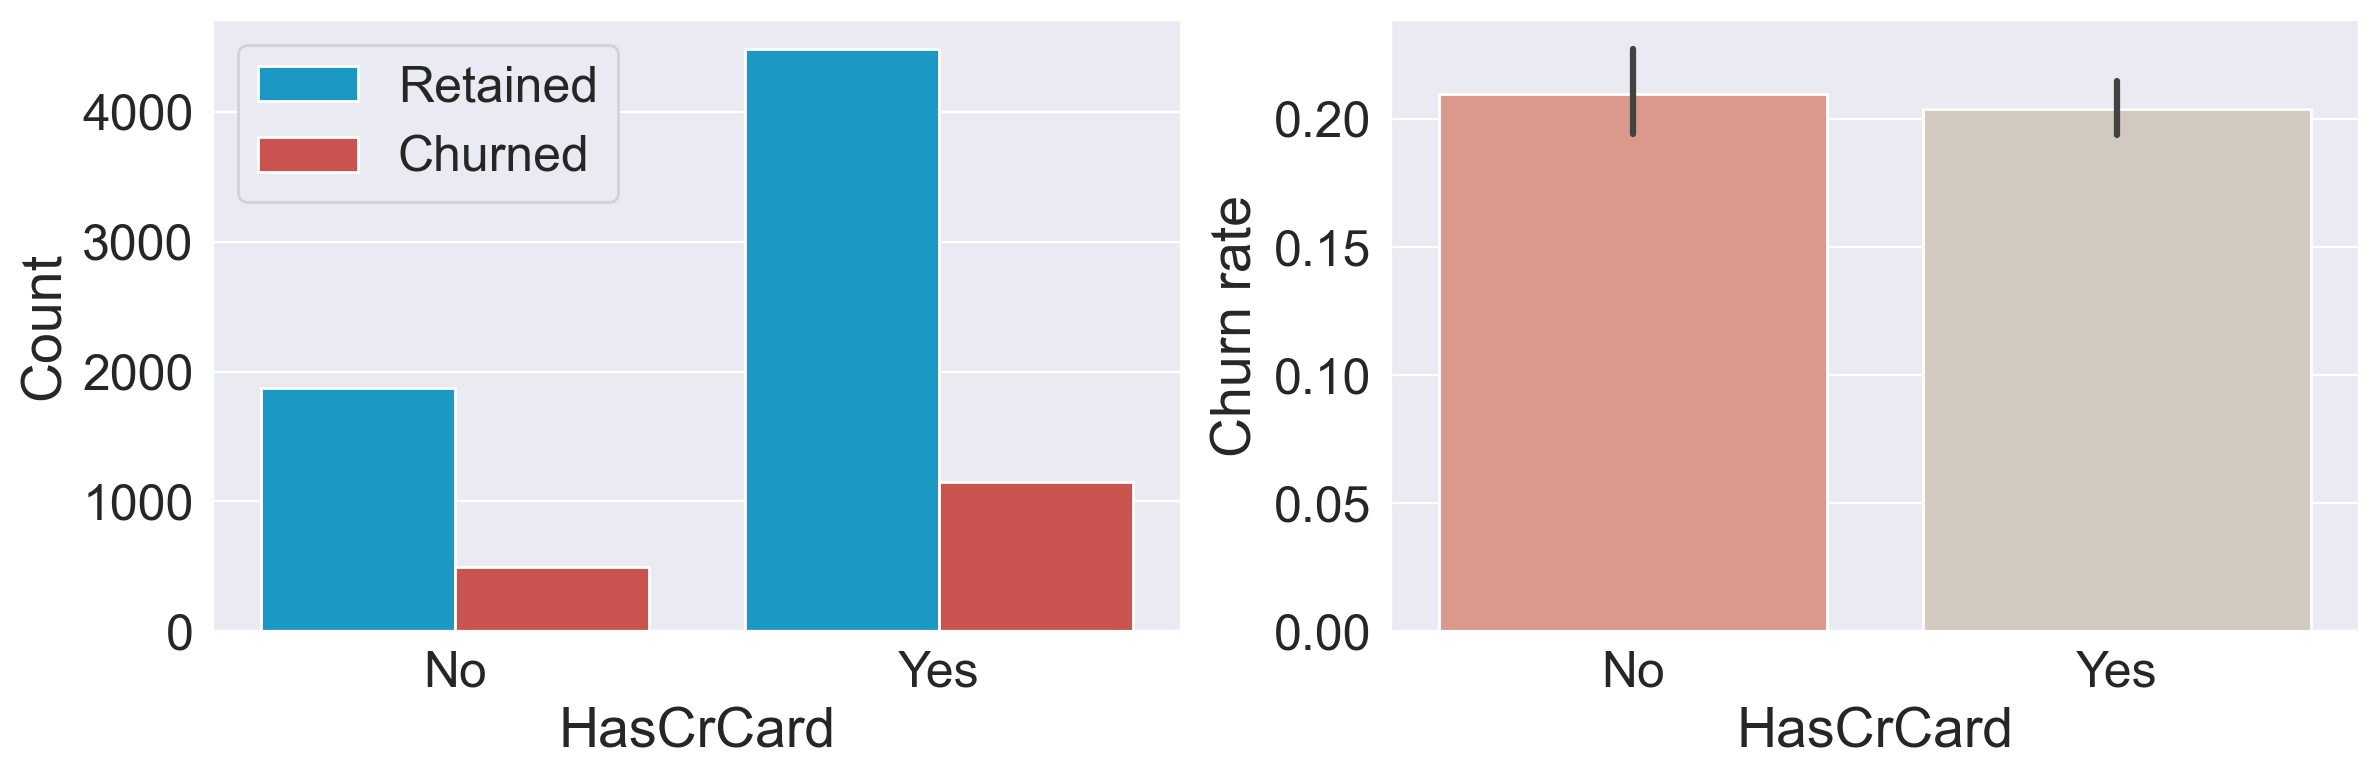

In [211]:
plot_categorical('HasCrCard')

Kredi kartına sahip olmak, hizmetten ayrılma oranını etkilemiyor gibi görünüyor.

### Active Members

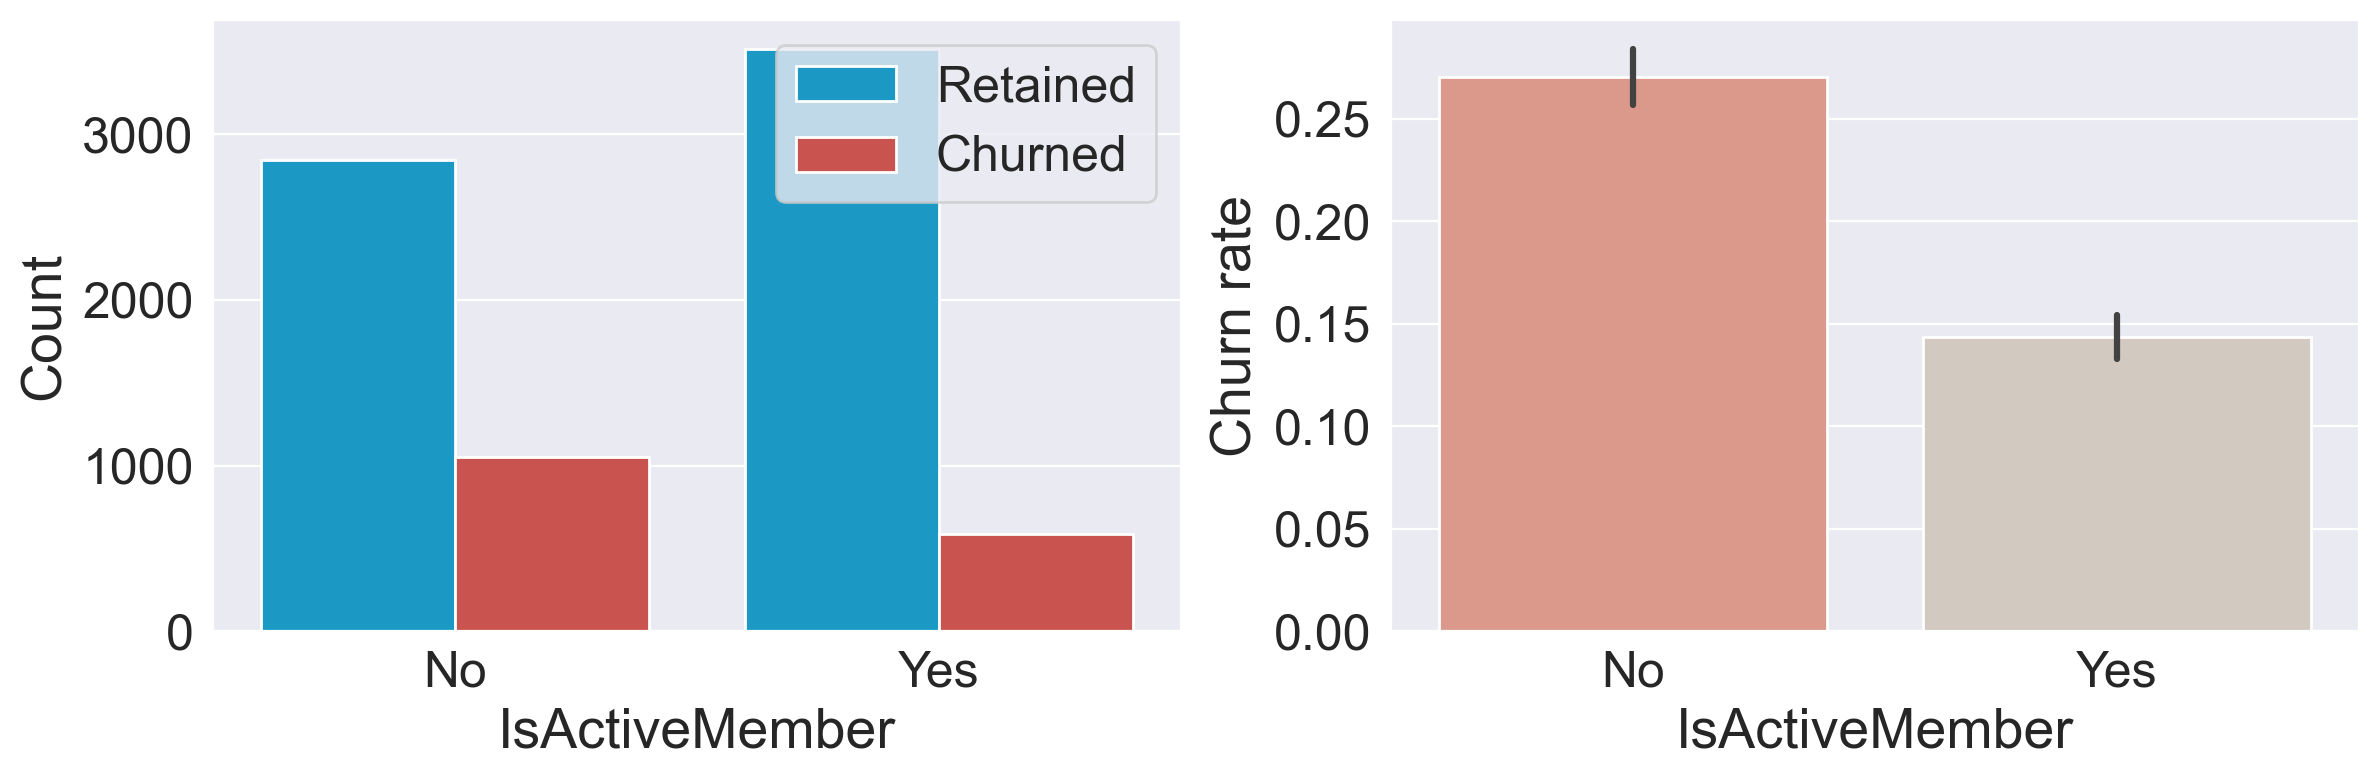

In [214]:
plot_categorical('IsActiveMember')

İnaktif müşterilerin hizmetten ayrılma olasılığının daha yüksek olması şaşırtıcı değildir. Müşterilerin önemli bir kısmı aktif değil; bu yüzcen, daha fazla müşterinin aktif olmasını sağlamak için bankanın politikasını değiştirmesi faydalı olacaktır.








# *Veri Önişleme(Data Preprocessing)*

Veri Ön İşleme, ham veriyi, Makine Öğrenmesi modelleri oluşturma ve eğitme için uygun bir formatta okunabilir hale getirme sürecidir.

Adımları sırayla tamamlayalım.

## Özellik Seçimi (Feature Selection)
Notebook'un başlangıcında, 'RowNumber', 'CustomerId' ve 'Surname' sütunlarını çıkartarak özellik seçimi yaptık. Keşifsel Veri Analizi (EDA) sırasında hedef değişkenimizi tahmin etmek için bir değer sağlamayan bazı diğer özellikleri de belirledik:  

* 'EstimatedSalary': Hem hizmetten ayrılan hem de kalan müşteriler için uniform (eşit) bir dağılım sergiliyor, bu yüzden çıkarılabilir.
    
* 'Tenure' ve 'HasCrCard': Bu özelliklerin kategorileri benzer hizmetten ayrılma oranlarına(churn rate) sahip, bu nedenle gereksiz olduğu düşünülüyor. Bu durum, bir ki-kare testi ile de doğrulanabilir. 

In [219]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

Variable  Chi-square     p-value
3   NumOfProducts    1233.595  3.767e-267
0       Geography     230.748   7.829e-51
5  IsActiveMember     195.315   2.199e-44
1          Gender      90.173   2.183e-21
2          Tenure      15.197   1.250e-01
4       HasCrCard       0.301   5.833e-01

'Tenure' ve 'HasCrCard' sütunlarının küçük bir ki-kare değerine ve 0.05'ten büyük bir p-değerine sahip olması, bu iki özelliğin herhangi bir anlamlı bilgi taşımadığını doğrulamaktadır. Bu, başlangıç hipotezimizi destekliyor.

Bu üç özelliği ('EstimatedSalary', 'Tenure', 'HasCrCard') eğitim setinden çıkarmak için drop() metodunu kullanabiliriz.

In [221]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

In [222]:
print(train_df.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'Exited'],
      dtype='object')


## Encoding Categorical Features

### Kategorik Özelliklerin Kodlanması
Makine öğrenmesi algoritmaları genellikle tüm giriş ve çıkış özelliklerinin sayısal olmasını gerektirir. Bu yüzden, kategorik özellikleri modelleri oluşturmadan önce sayılara dönüştürülmeliyiz.

Veri setimizde dönüşüm gerektiren iki özellik bulunuyor:

* 'Gender' (Cinsiyet): Scikit-learn'ün LabelEncoder() yöntemini kullanacağız. Bu yöntem, her bir benzersiz etiketi bir tamsayıya eşler (Male --> 1 ve Female --> 0).
 
* 'Geography' (Coğrafya): Kodlama işlemini manuel olarak yapacağız, böylece Almanya'daki müşteriler 1 değerine, Fransa ve İspanya 0 değerine sahip olacak. Bu yöntemi seçtim çünkü diğer iki ülkedeki müşteriler için hizmetten ayrılma oranı neredeyse eşit ve Almanya'dakinden oldukça düşük. Bu yüzden, bu özelliği Alman ve Alman olmayan müşteriler arasında ayrım yapacak şekilde kodlamak daha mantıklı geldi. Ayrıca, bu özelliği one-hot encoding yöntemiyle (get_dummies()) kodlamayı denedim ve Fransa ve İspanya için oluşturulan iki yeni özelliğin önem derecesinin düşük olduğunu gördüm.

In [225]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

## Feature Scaling
Özellik ölçekleme, bir veri setindeki özelliklerin aralıklarını normalleştirmek için kullanılan bir tekniktir. Bazı algoritmalar, özellik ölçeklemeye duyarlıdır (örneğin, SVM'ler), bazıları ise ölçeklemeden etkilenmez (örneğin, Rastgele Ormanlar).

StandardScaler() kullanmaya karar verdim. Bu yöntem, her bir özelliği standartlaştırarak ortalamadan çıkarır ve standart sapmaya böler. Bu dönüşüm, ortalaması sıfır ve varyansı bir olan özellikler üretir.

In [227]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

Son olarak, eğitim setini 'X_train' ve 'y_train' setlerine böleceğiz:

* X_train: Girdi (bağımsız) özellikler.
* y_train: Çıktı (bağımlı) hedef değişken.

In [229]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', axis=1)

## Sınıf Dengesizliğini Ele Alma (Addressing Class Imbalance)

Daha önce gördüğümüz gibi, tahmin edilecek sınıflar arasında bir dengesizlik bulunmaktadır. Bir sınıf (0 – retained) diğerine (1 – churned) göre çok daha yaygındır

In [232]:
y_train.value_counts()

Exited
0    6356
1    1644
Name: count, dtype: int64

Sınıf dengesizliği genellikle bir sorun teşkil eder ve birçok gerçek dünya görevinde ortaya çıkar. Dengesiz verilerle sınıflandırma, çoğunluk sınıfı lehine bir önyargıya sahiptir; bu, makine öğrenimi algoritmalarının çoğunluk sınıfını tahmin etmekten öteye geçmeyen modeller üretmesi anlamına gelir. Ayrıca, dengesiz verilerle çalışırken yaygın kullanılan metrikler yanıltıcı olabilir (örneğin, bir veri seti %99.9 oranında 0 ve %0.01 oranında 1 içeriyorsa, her zaman 0 tahmini yapan bir sınıflandırıcı %99.9 doğruluk oranına sahip olacaktır).

Neyse ki, bu sorunu çözmek için bazı stratejiler bulunmaktadır. SMOTE ('Synthetic Minority Oversampling Technique') algoritmasını kullanmaya karar verdim. SMOTE algoritması Yukarı örneklenen bir kayda benzer bir kayıt bulur ve orijinal kayıt ile komşu kaydın rastgele ağırlıklı ortalaması olan sentetik bir kayıt oluşturur. Ağırlık, her bir tahmin edici (predictor) için ayrı ayrı üretilir.

imblearn kütüphanesinden SMOTE fonksiyonunu, sampling_strategy parametresini 'auto' olarak ayarlayarak kullanacağım.

In [234]:
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

Exited
0    6356
1    6356
Name: count, dtype: int64

# Makine Öğrenimi Modelleri Oluşturma

## Temel Modeller (Baseline Models)


Bu bölüme, eğitim setindeki temel performansı (baseline performance) tahmin etmek için iki basit model oluşturarak başlayacağım. Özellikle, Gaussian Naive Bayes ve Lojistik Regresyon modellerini kullanacağım. Bu modellerin varsayılan parametrelerini kullanarak, k-katlı çapraz doğrulama (k-fold cross-validation) yöntemiyle ortalama duyarlılıklarını (mean recall) değerlendireceğim.

K-katlı çapraz doğrulama fikri aşağıda görüldüğü gibi çok basittir:
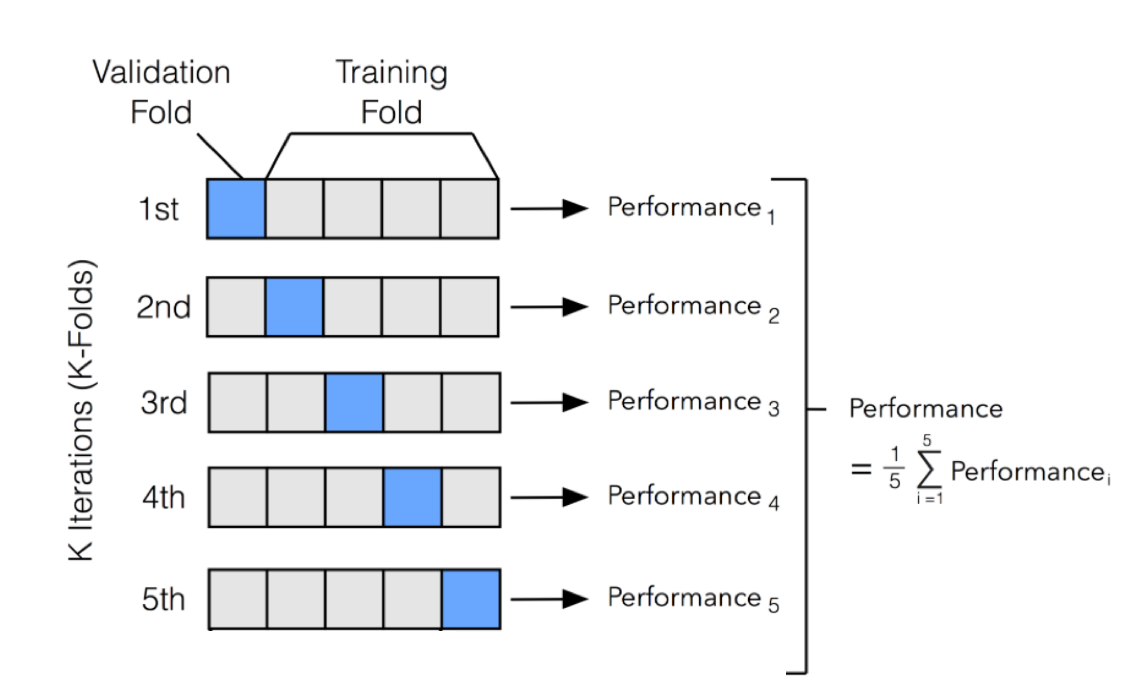
* Eğitim setini k alt kümeye (fold) böler.
* Modeli k-1 fold üzerinde eğitir ve geriye kalan fold üzerinde modeli değerlendirir.
* Bu işlem, her fold bir kez test edilene kadar tekrarlanır.

In [238]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.7
   Logistic Regression: 0.69


Not: Daha güçlü sınıflandırıcılar, örneğin Random Forests veya XGBoost, kullanabilirdik. Ancak, bu aşamada bu modelleri hariç tutmayı tercih ettim çünkü varsayılan parametreleri, eğitim setine aşırı uyum (overfitting) sağlama olasılıklarını artırır ve bu da temel performans değerlendirmesinde yanıltıcı sonuçlara yol açabilir.

## Model Tuning (Model Ayarlama)

Artık makine öğrenimi modelleri oluşturmaya hazırız. Bunun için 6 Farklı Classifier seçtim:

* Logistic Regression
* Support Vector Classifier
* Random Forest Classifier
* Gradient Boosting Classifier
* XGBoost
* LightGBM
  
Hiperparametre Ayarı
Varsayılan hiperparametreleri kullanmak genellikle veri setine aşırı uyum (overfitting) veya eksik uyum (underfitting) sağlayan, optimize edilmemiş modellerle sonuçlanır. Hiperparametre ayarı, en iyi performansı sağlayan hiperparametre değerlerini bulma sürecidir. Bunun için önce hangi hiperparametrelerle denemeler yapacağımızı ve hangi değerleri deneyeceğimizi tanımlayacağız. Bu bilgiyi Scikit-Learn'ün GridSearchCV yöntemine aktaracağız. Bu yöntem, hiperparametre değerlerinin tüm olası kombinasyonlarını değerlendirir. Daha önce belirtildiği gibi, modellerimizi optimize etmek için recall metriği kullanacağım. Ayrıca, GridSearchCV, k-fold cross-validation yöntemiyle değerlendirir, bu nedenle bir katlama sayısı (cv) belirlenmesi gerekir.

Her sınıflandırıcı için bir karışıklık matrisi(confusion matrix) ile birlikte bir öğrenme eğrisi grafiği sunulacaktır. Öğrenme eğrileri, bir modelin eğitim seti ve doğrulama seti üzerindeki performansını, eğitim seti boyutunun bir fonksiyonu olarak çizer. Bu grafikler, aşırı uyum/eksik uyumu ve eğitim boyutunun model hatası üzerindeki etkisini görselleştirmemize yardımcı olabilir.

### Logistic Regression


 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


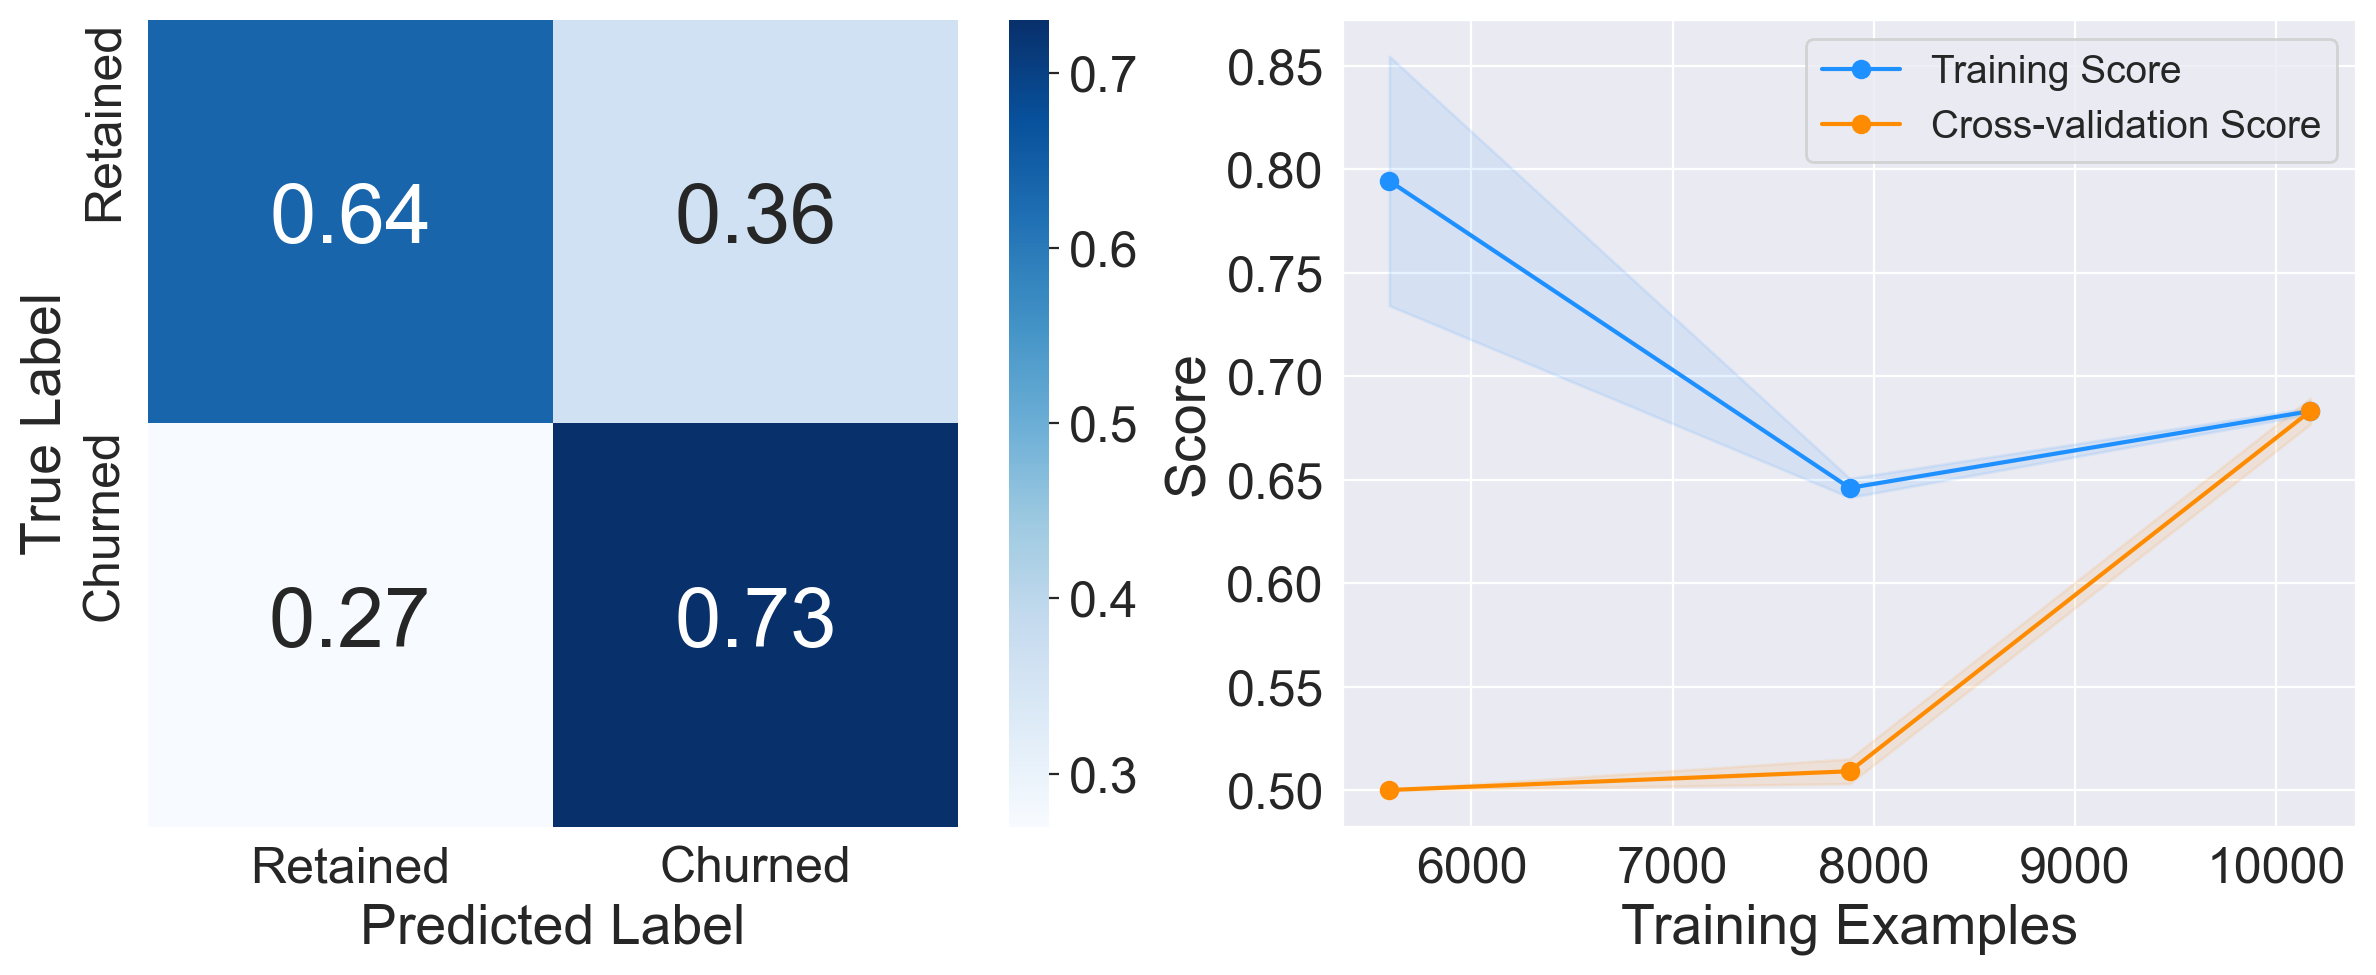

In [243]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

### Support Vector Classifier


 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      C: 2
      gamma: scale
      kernel: rbf


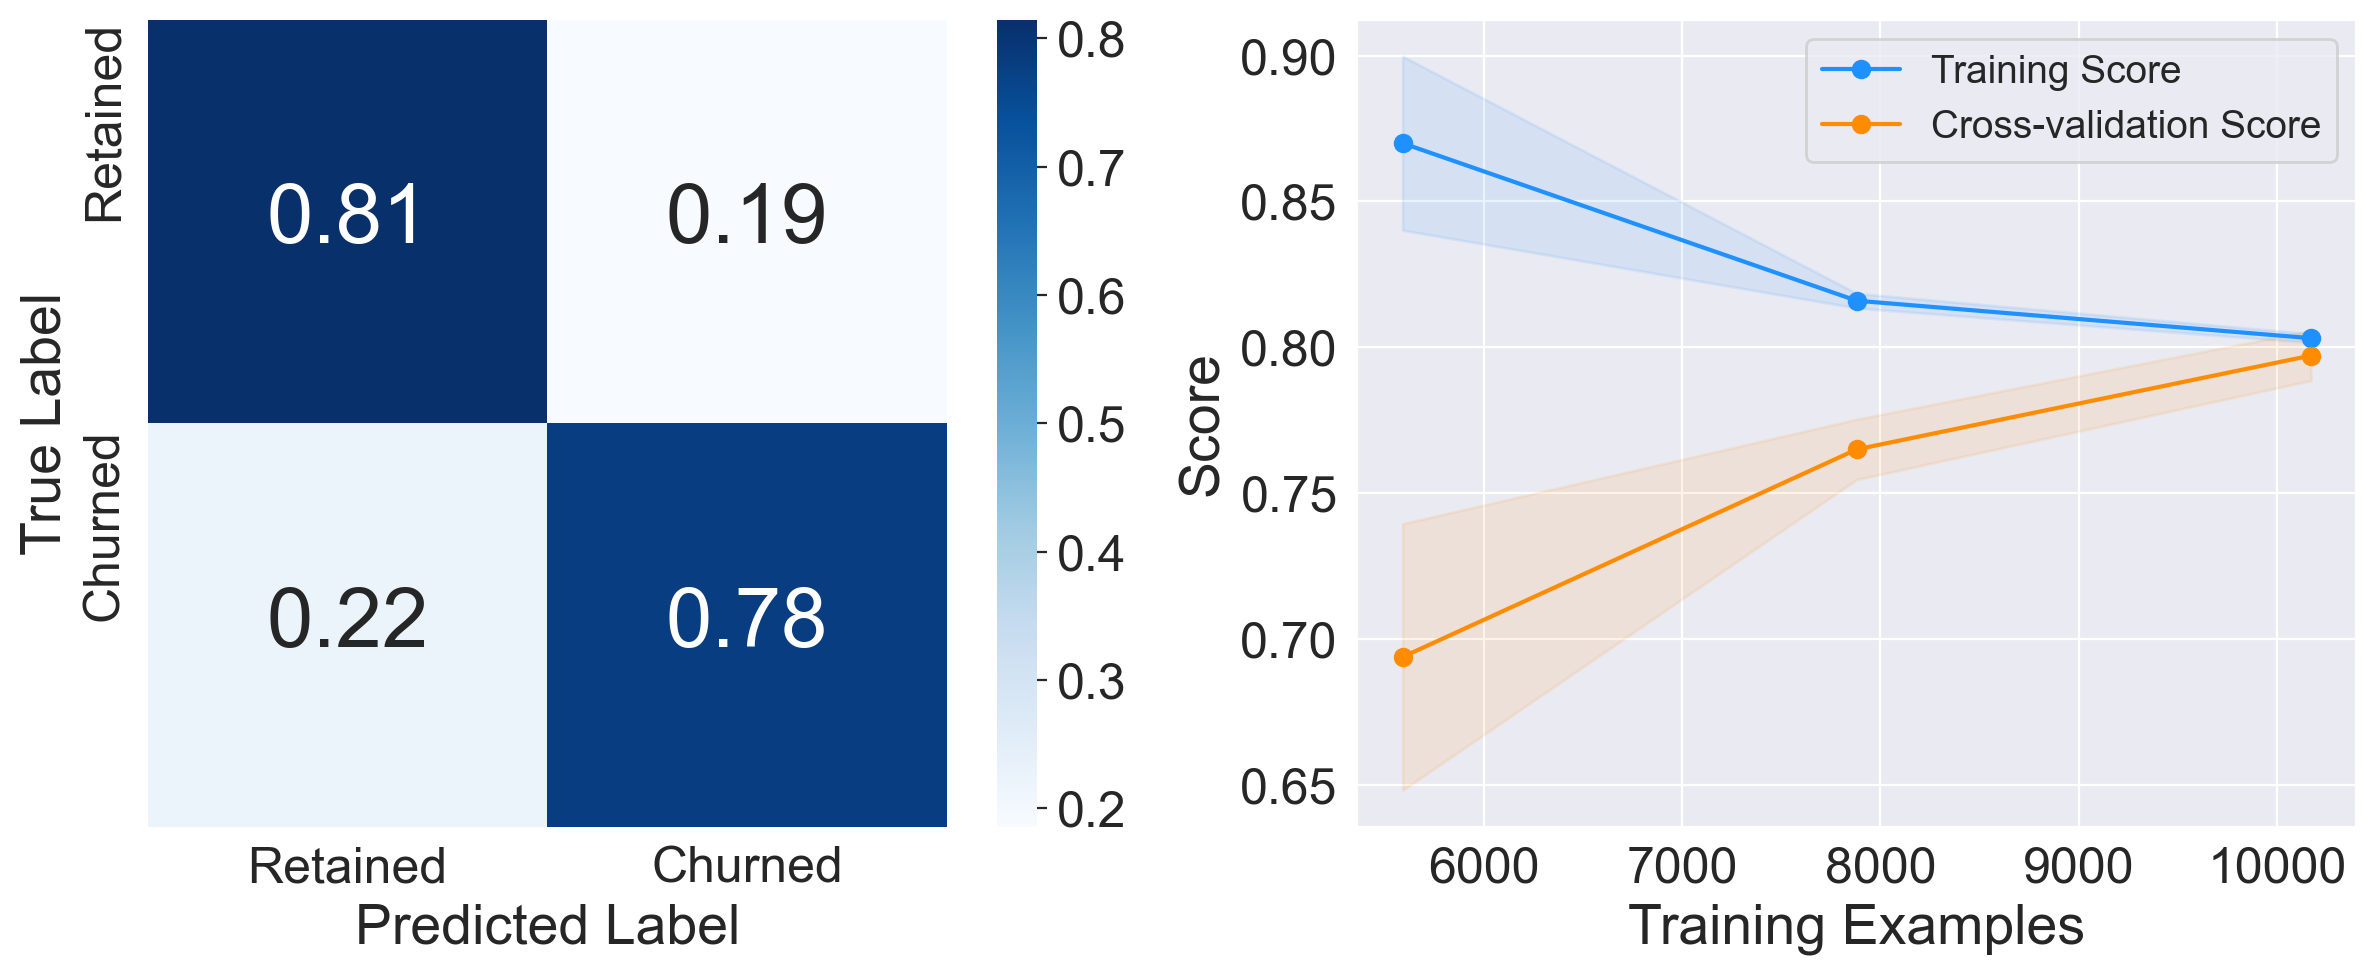

In [245]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

### Random Forest


 Random Forest
-------------------------------
   Best Score (recall): 0.77
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: sqrt
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


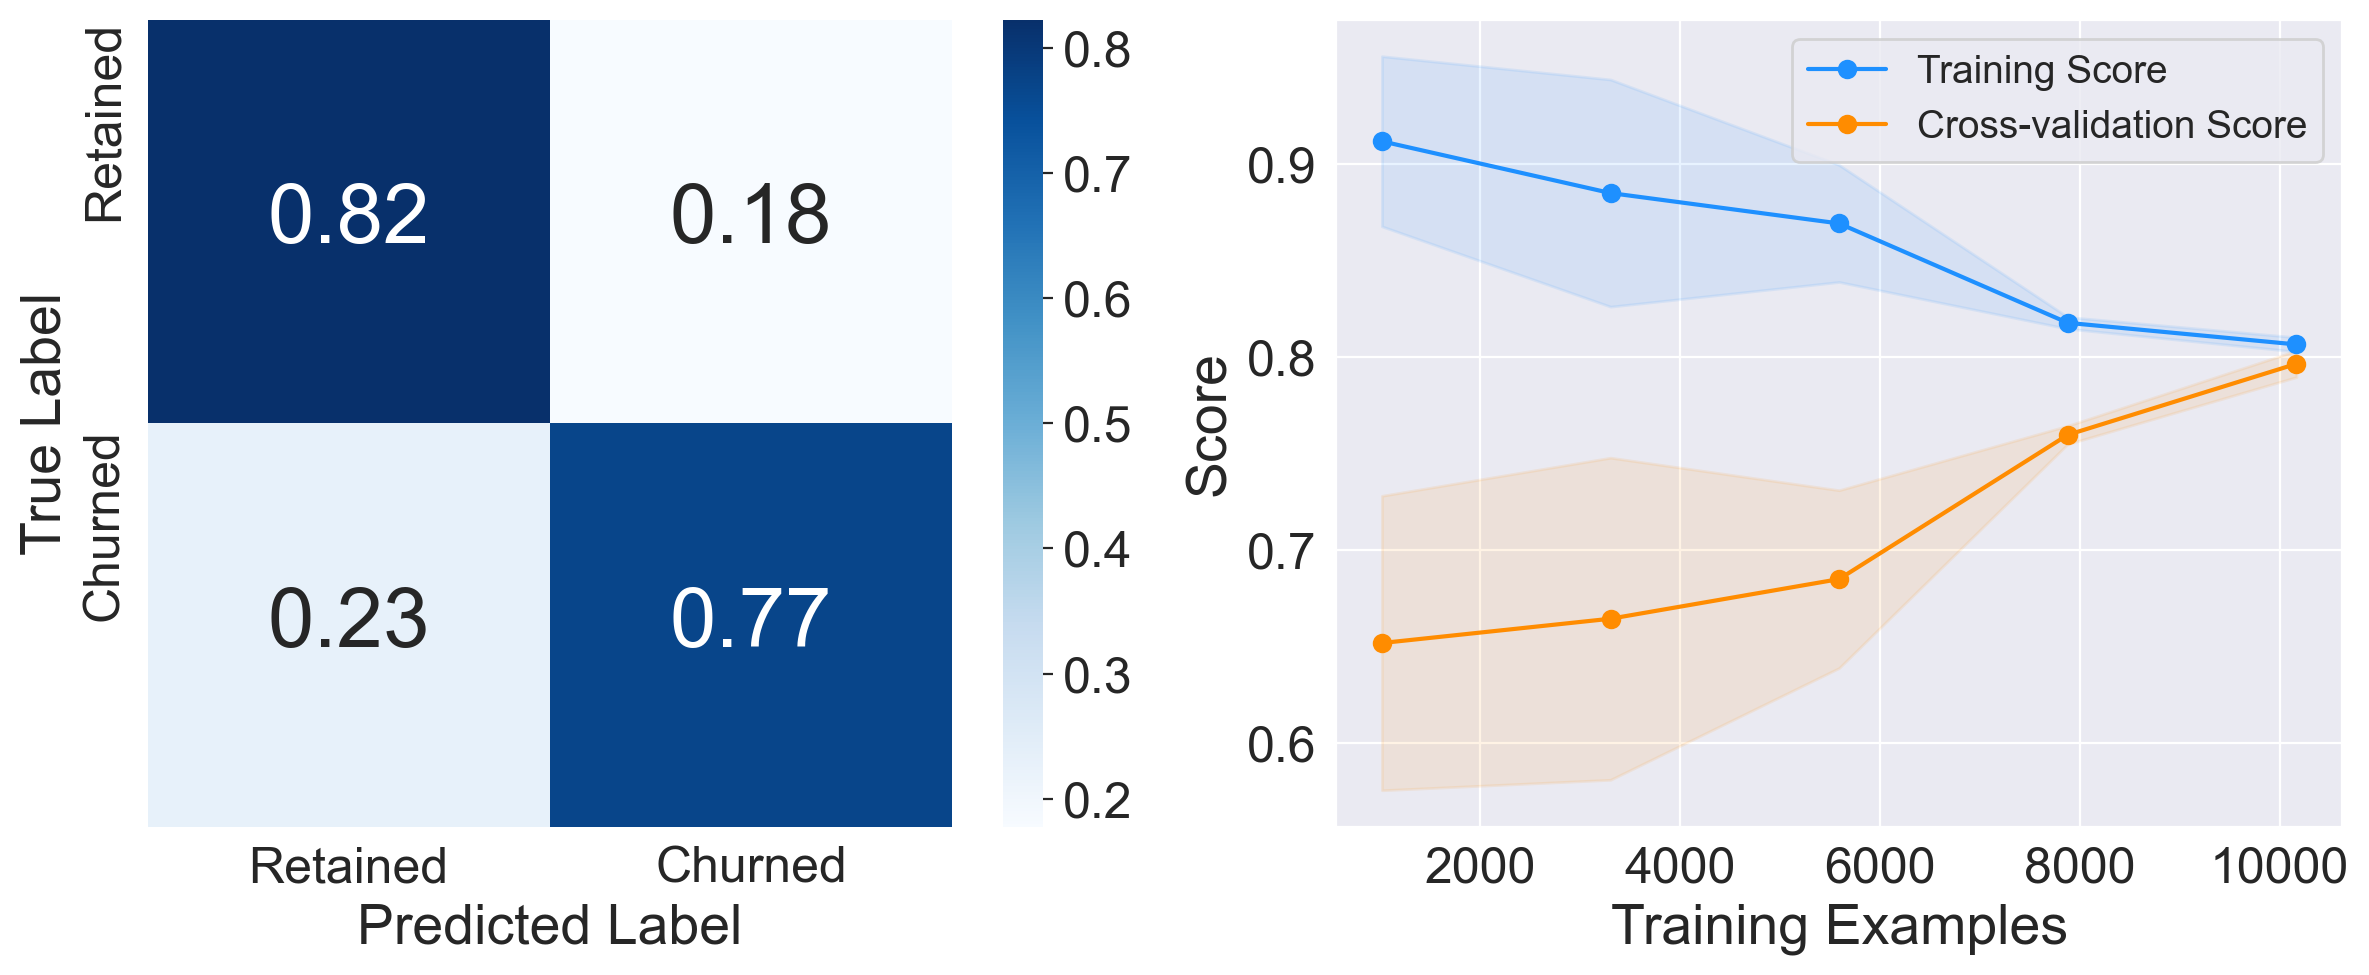

In [247]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

### Gradient Boosting Classifier


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.755
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: None
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


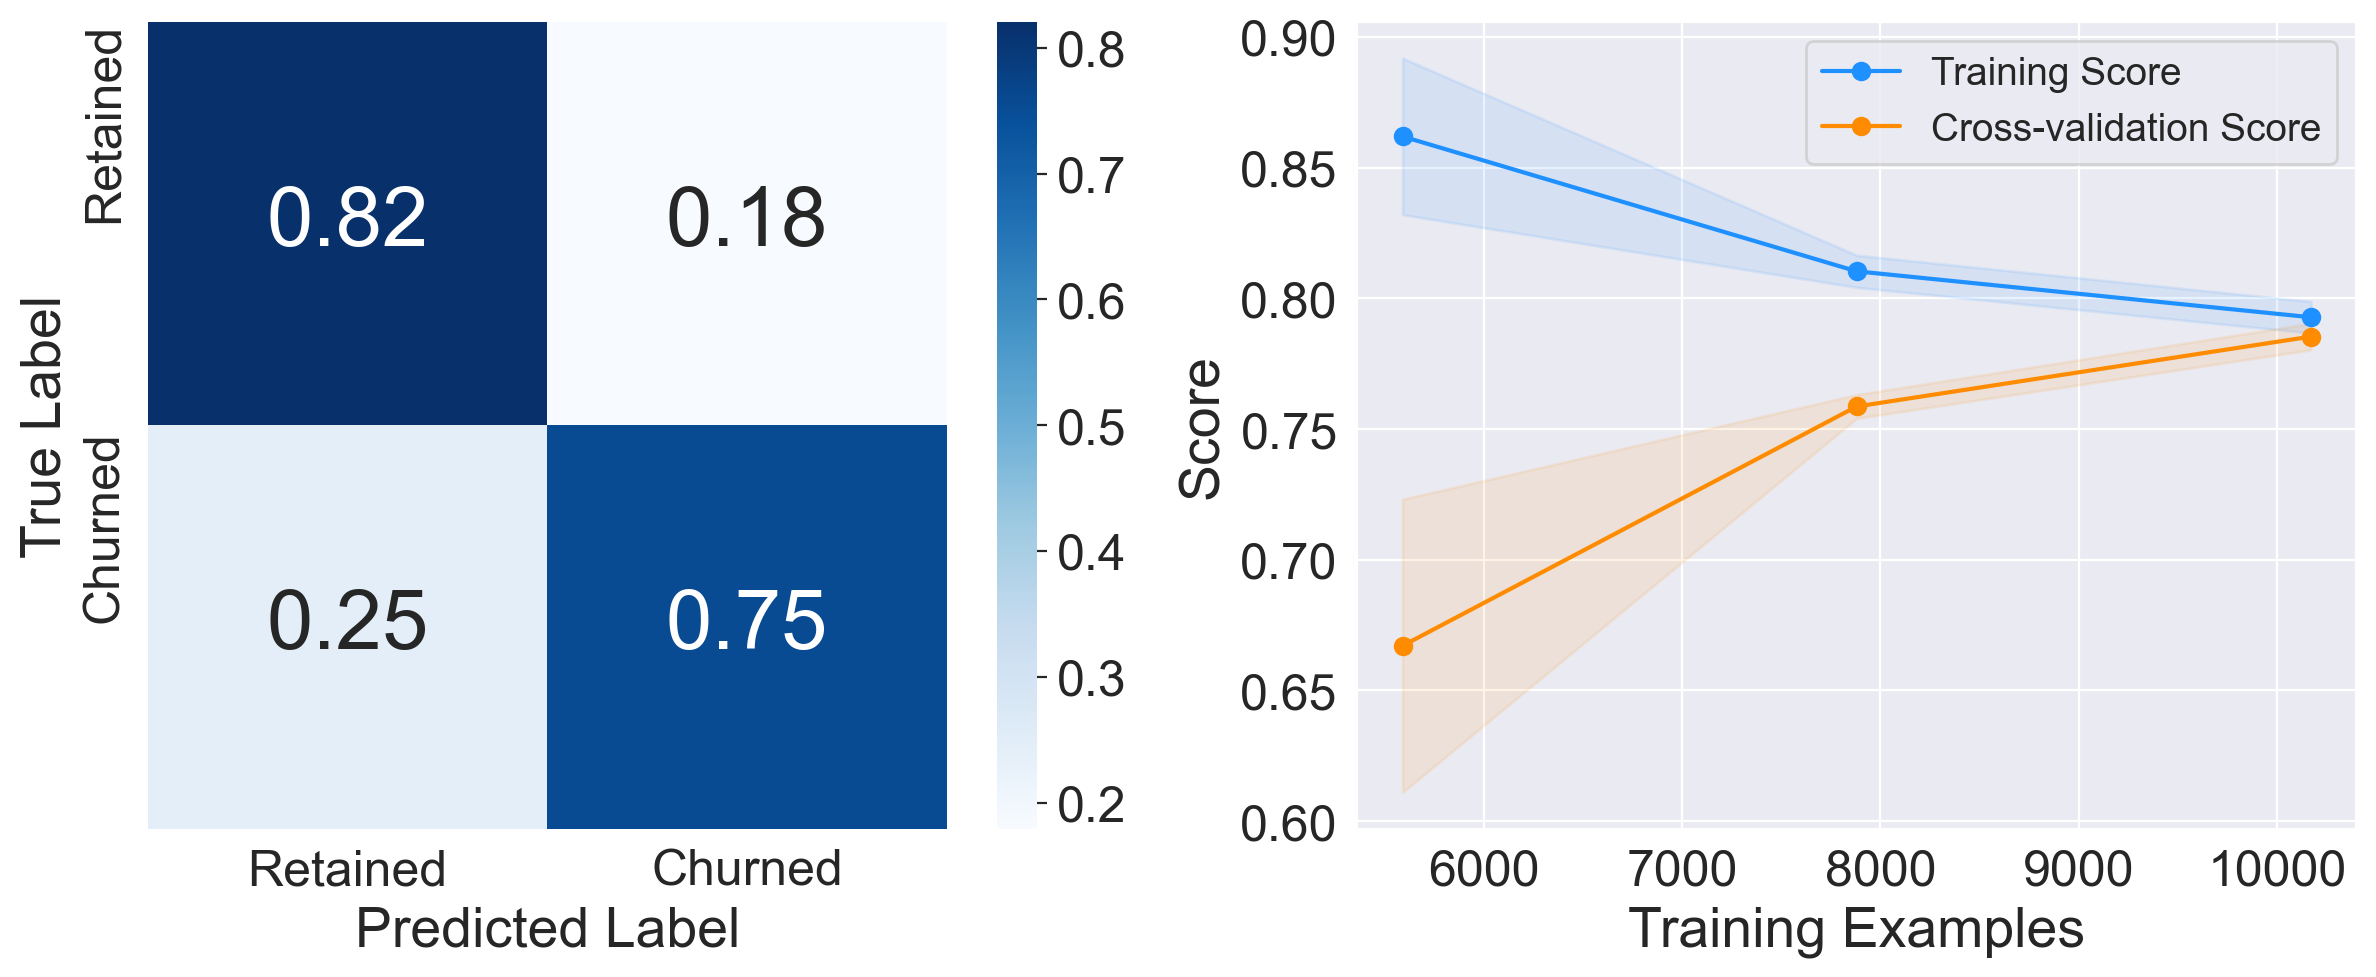

In [249]:
gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

Erken durdurma sonrası tahmincilerin (estimators) sayısı şu şekildedir:

In [251]:
best_gbc_clf.best_estimator_.n_estimators_

284

### XGBoost Classifier


 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.775
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 1
      learning_rate: 0.01
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75


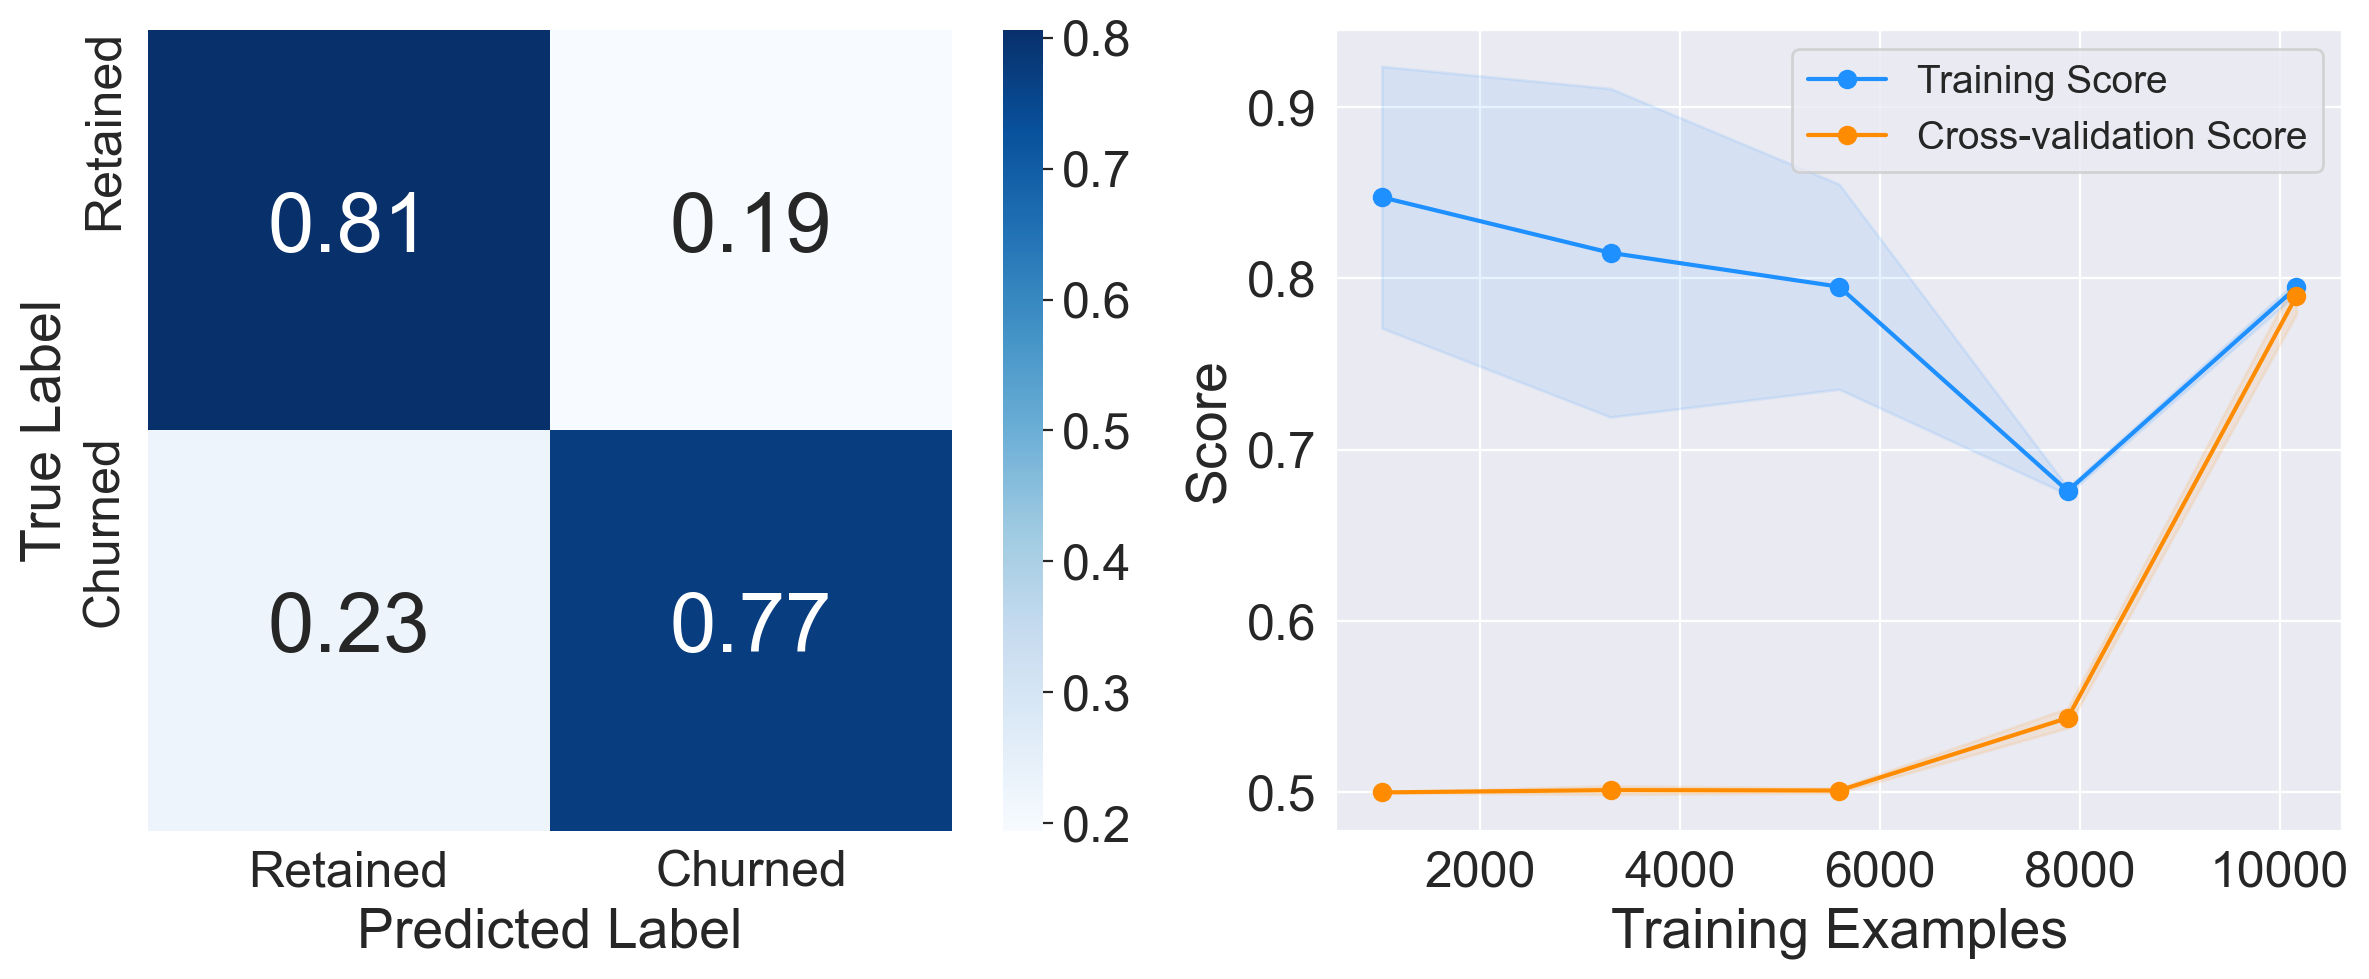

In [253]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

### LGBMClassifier

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 6356, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.779
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
      r

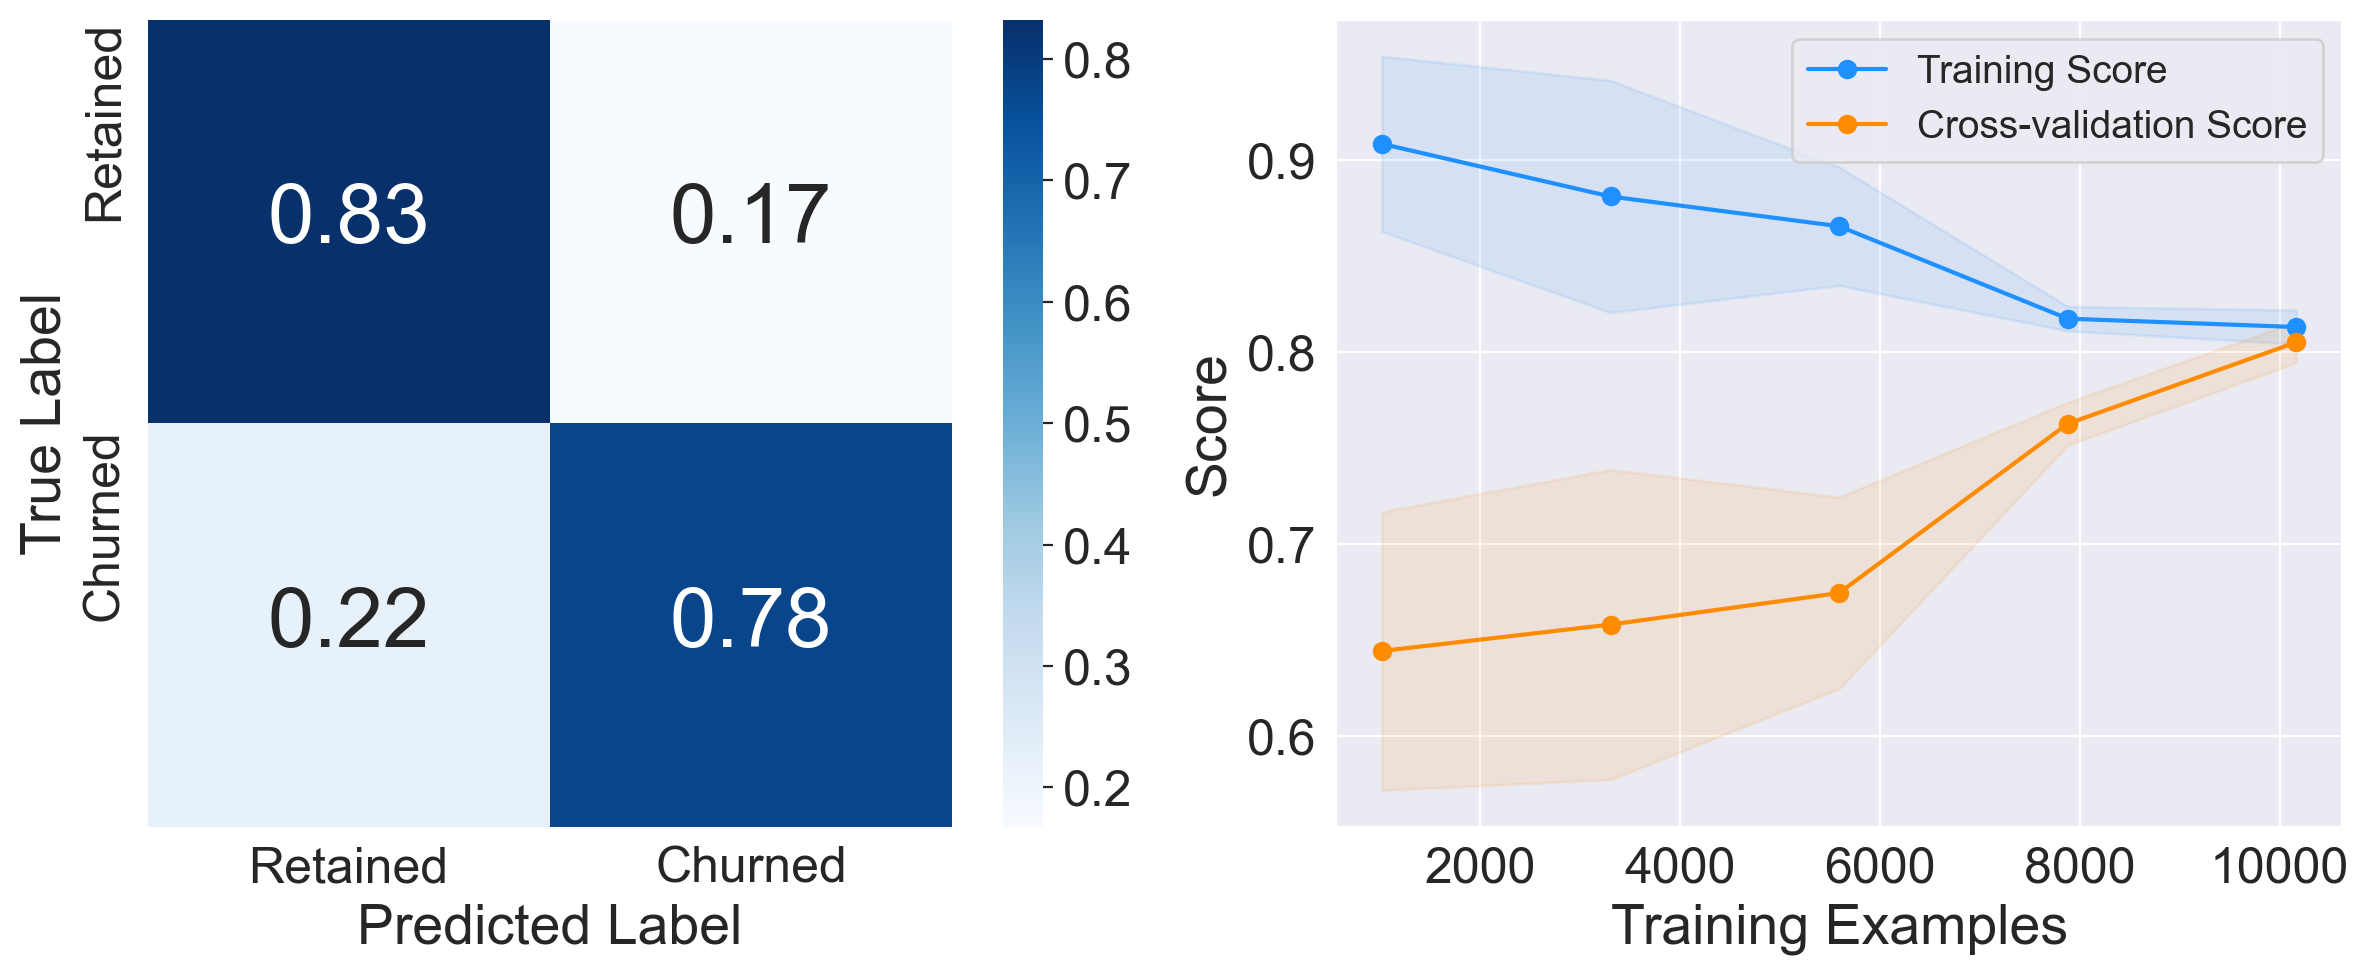

In [255]:
lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')

### Ensemble Learning
Bu sınıflandırıcıların tümünün tahminlerini birleştirerek, her bir sınıflandırıcının bireysel performansına kıyasla daha iyi bir tahmin performansı elde edip edemeyeceğimizi belirleyebiliriz. Bu yaklaşım, Ensemble Learning (Topluluk Öğrenmesi) yönteminin temel motivasyonudur.

Özellikle, Soft Voting (Yumuşak Oy Verme) yöntemini kullanacağım. Bu durumda, her bir sınıflandırıcı, belirli bir veri noktasının belirli bir hedef sınıfa ait olma olasılığına dair bir değer sağlar. Bu tahminler, sınıflandırıcının önemine göre ağırlıklandırılır ve toplanır. Daha sonra, ağırlıklı olasılıkların toplamının en büyük olduğu hedef etiket oyları kazanır.

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
Soft Voting
-----------------
  Recall:  0.786


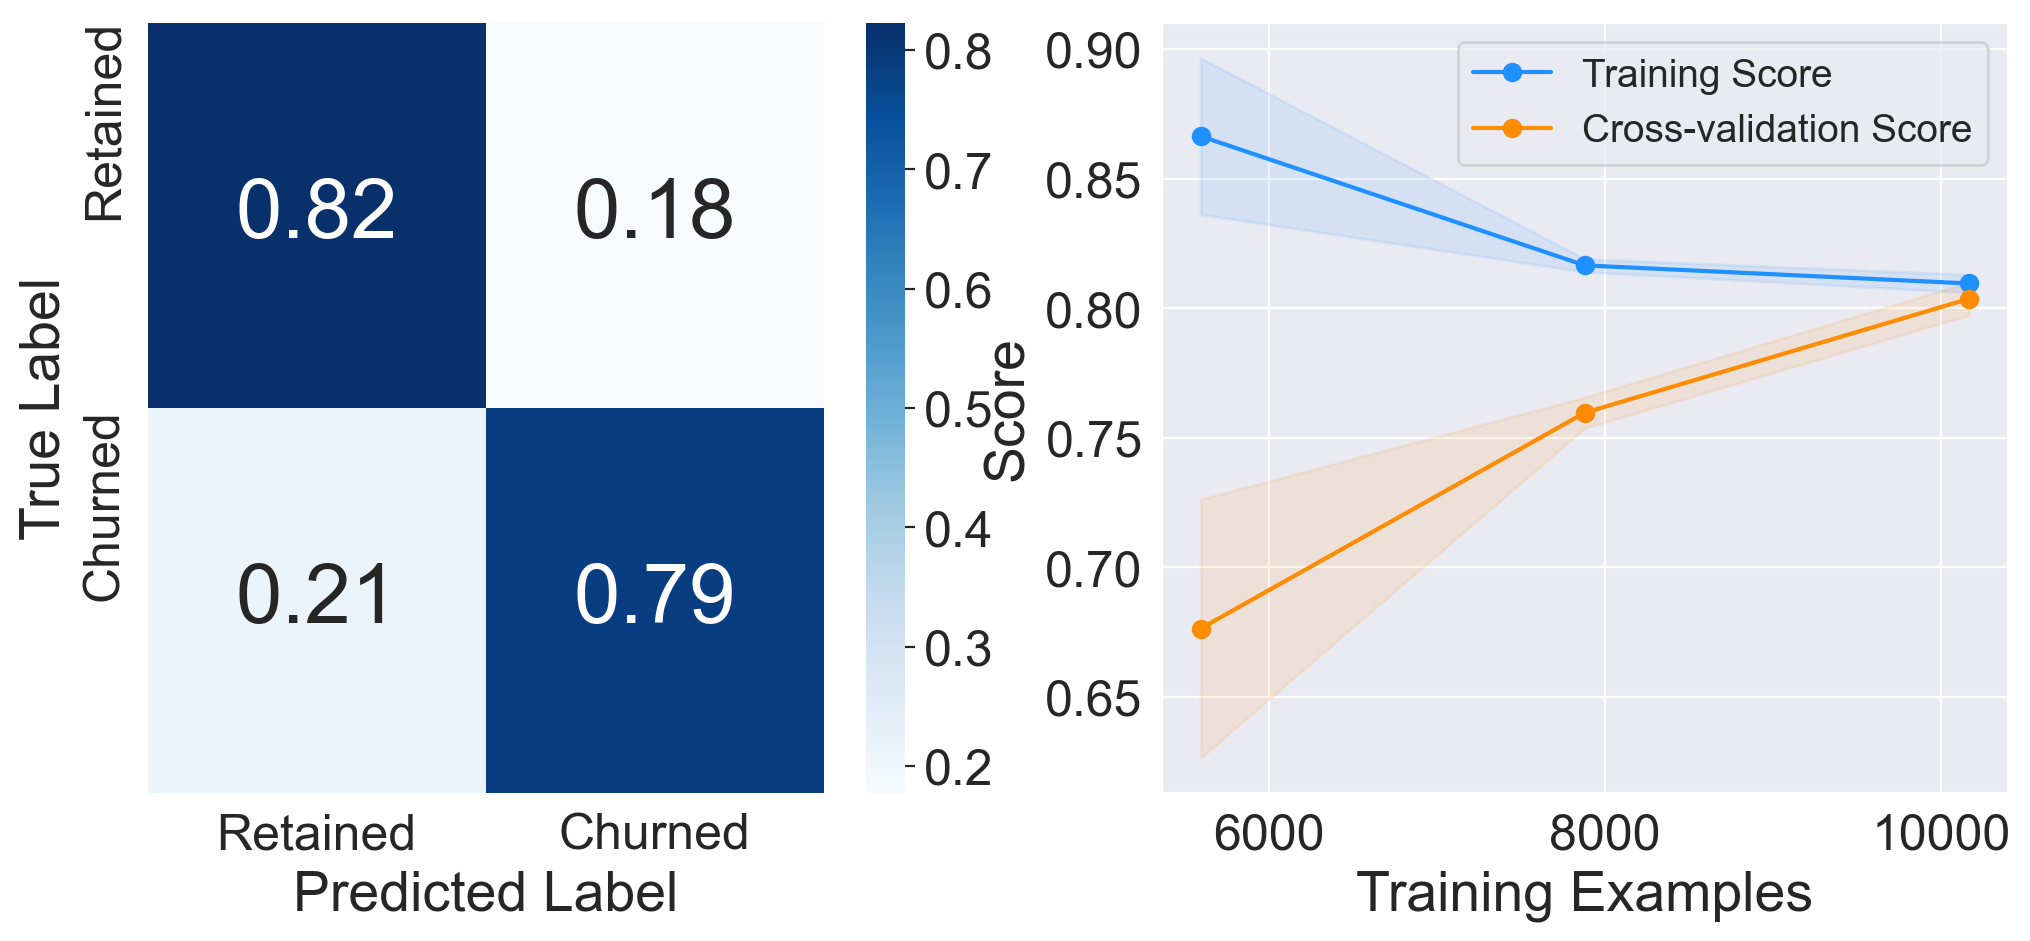

In [257]:
estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBMC', best_lgbmc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

# Results

## Learning Curves(Öğrenme Eğrileri)
Tüm modellerde, eğitim sonunda iki eğri arasında çok küçük bir fark bulunmaktadır. Bu gözlem, eğitim setine aşırı uyum (overfitting) sağlamadığımızı göstermektedir.

## Feature Importance

Bazı sınıflandırıcılar, özellik önemini görselleştirmemize olanak tanır:

In [ ]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

'Age' ve 'NumOfProducts' tüm sınıflandırıcılar için en faydalı özellikler gibi görünüyor; bunları 'IsActiveMember' ve 'Balance' izliyor. Öte yandan, 'CreditScore', LGBM dışında tüm tahminciler için sıfıra yakın küçük bir değerle en önemsiz özellik olarak görünüyor.

## Performans Karşılaştırması
İlk olarak, sınıflandırıcılarımızın performansını dört farklı metrik açısından karşılaştırabiliriz: Doğruluk (Accuracy), Hassasiyet (Precision), Duyarlılık (Recall) ve ROC eğrisi altındaki alan (AUC).

In [312]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

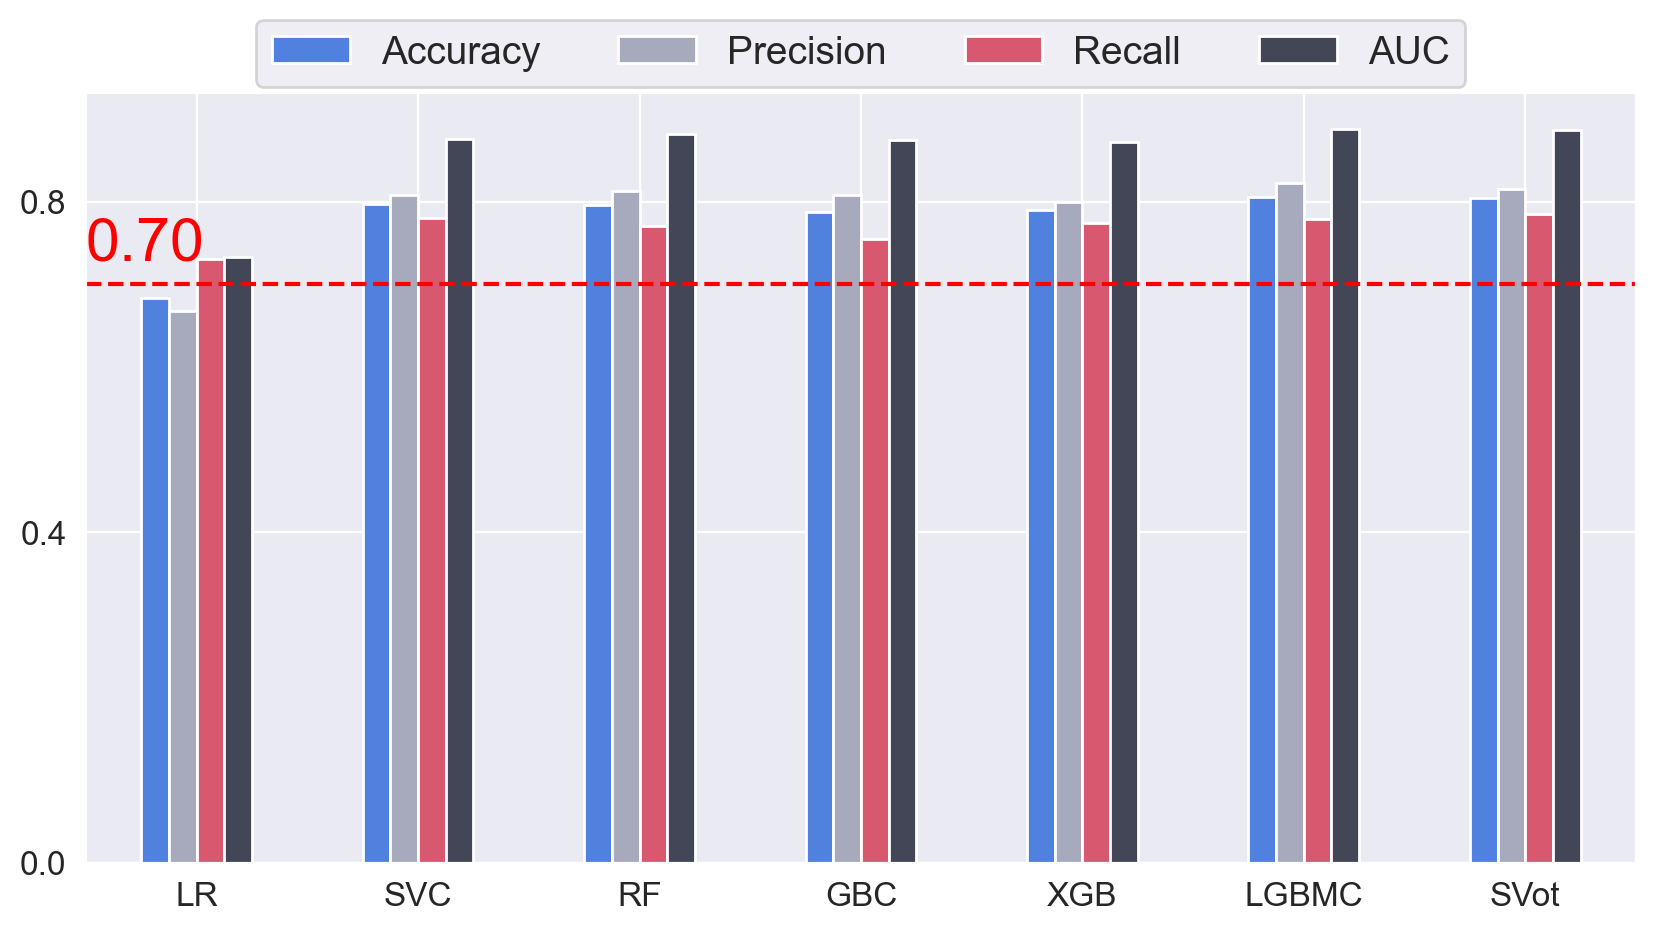

In [314]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

Diğer tüm sınıflandırıcılar, temel performans olan %70'ten daha yüksek bir duyarlılığa (recall) sahiptir. XGB, en yüksek duyarlılığa (%78.5) sahip modeldir. Ancak, LGBM sınıflandırıcı en yüksek doğruluk (accuracy), hassasiyet (precision) ve AUC ile genel olarak en iyi performansı sergilemektedir.

Sınıflandırma modellerinin tahmin performansını karşılaştırmak için yalnızca tek bir metriği kullanmak zorunda değiliz. ROC eğrisi (Receiver Operating Characteristic curve), farklı sınıflandırma eşiklerinde bir sınıflandırıcının performansını gösteren bir grafiktir. Bu eğri, gerçek pozitif oranını (recall olarak da bilinir) yanlış pozitif oranına karşı çizer.

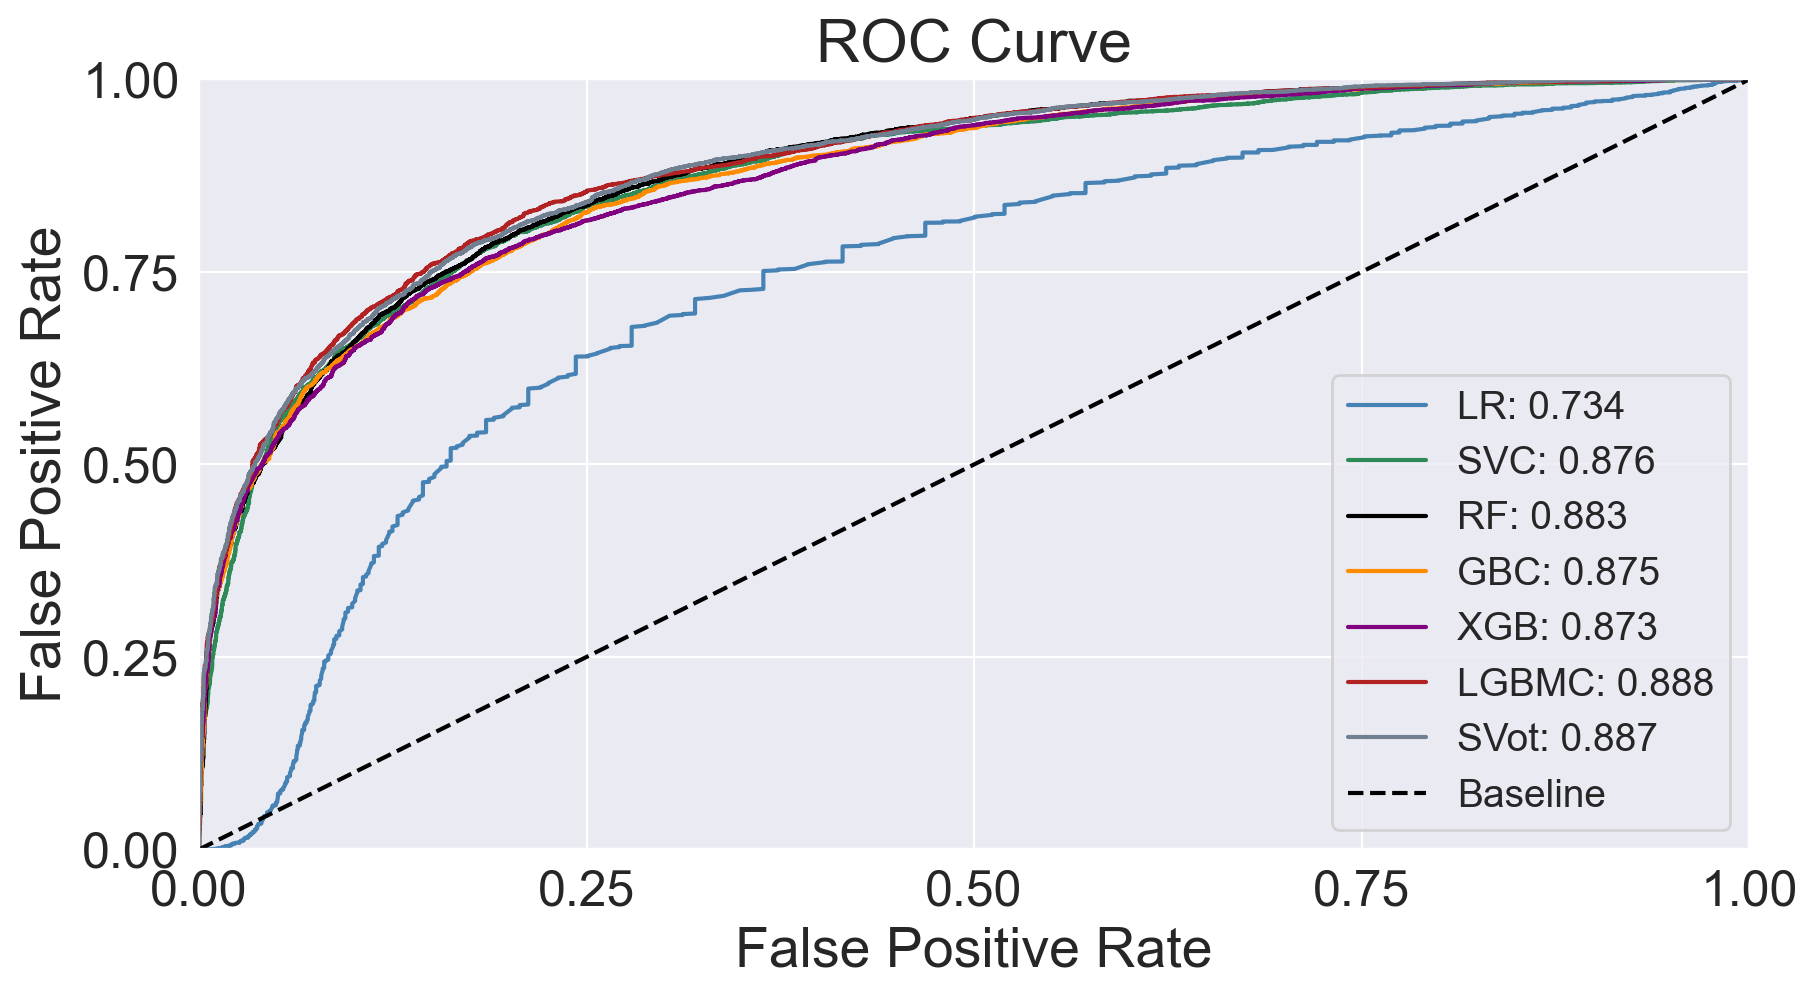

In [316]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

Kesikli diagonal çizgi, tamamen rastgele tahmin yapan bir sınıflandırıcıyı temsil eder; iyi bir sınıflandırıcı, bu çizgiden mümkün olduğunca uzaklaşarak (sol üst köşeye doğru) yer alır.

Bizim durumumuzda, Lojistik Regresyon dışında tüm sınıflandırıcılar benzer performans göstermektedir. Ancak, LGBM biraz daha yüksek bir AUC değeri (0.888) ile marjinal olarak daha iyi performans göstermektedir.

Son zamanlarda, bir sınıflandırıcı modelin performansını değerlendirmek için başka bir araçla karşılaştım: Kümülatif Kazanç (Cumulative Gain). Basitçe ifade etmek gerekirse, kümülatif kazanç, modele göre hedef sınıfa ait olma olasılığı en yüksek olan belirli bir yüzdeyi dikkate aldığınızda, ulaşılan hedeflerin yüzdesini gösterir. scikitplot kütüphanesi, bu grafiği kolayca çizmek için bir yöntem sunar:








Soft Voting:
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


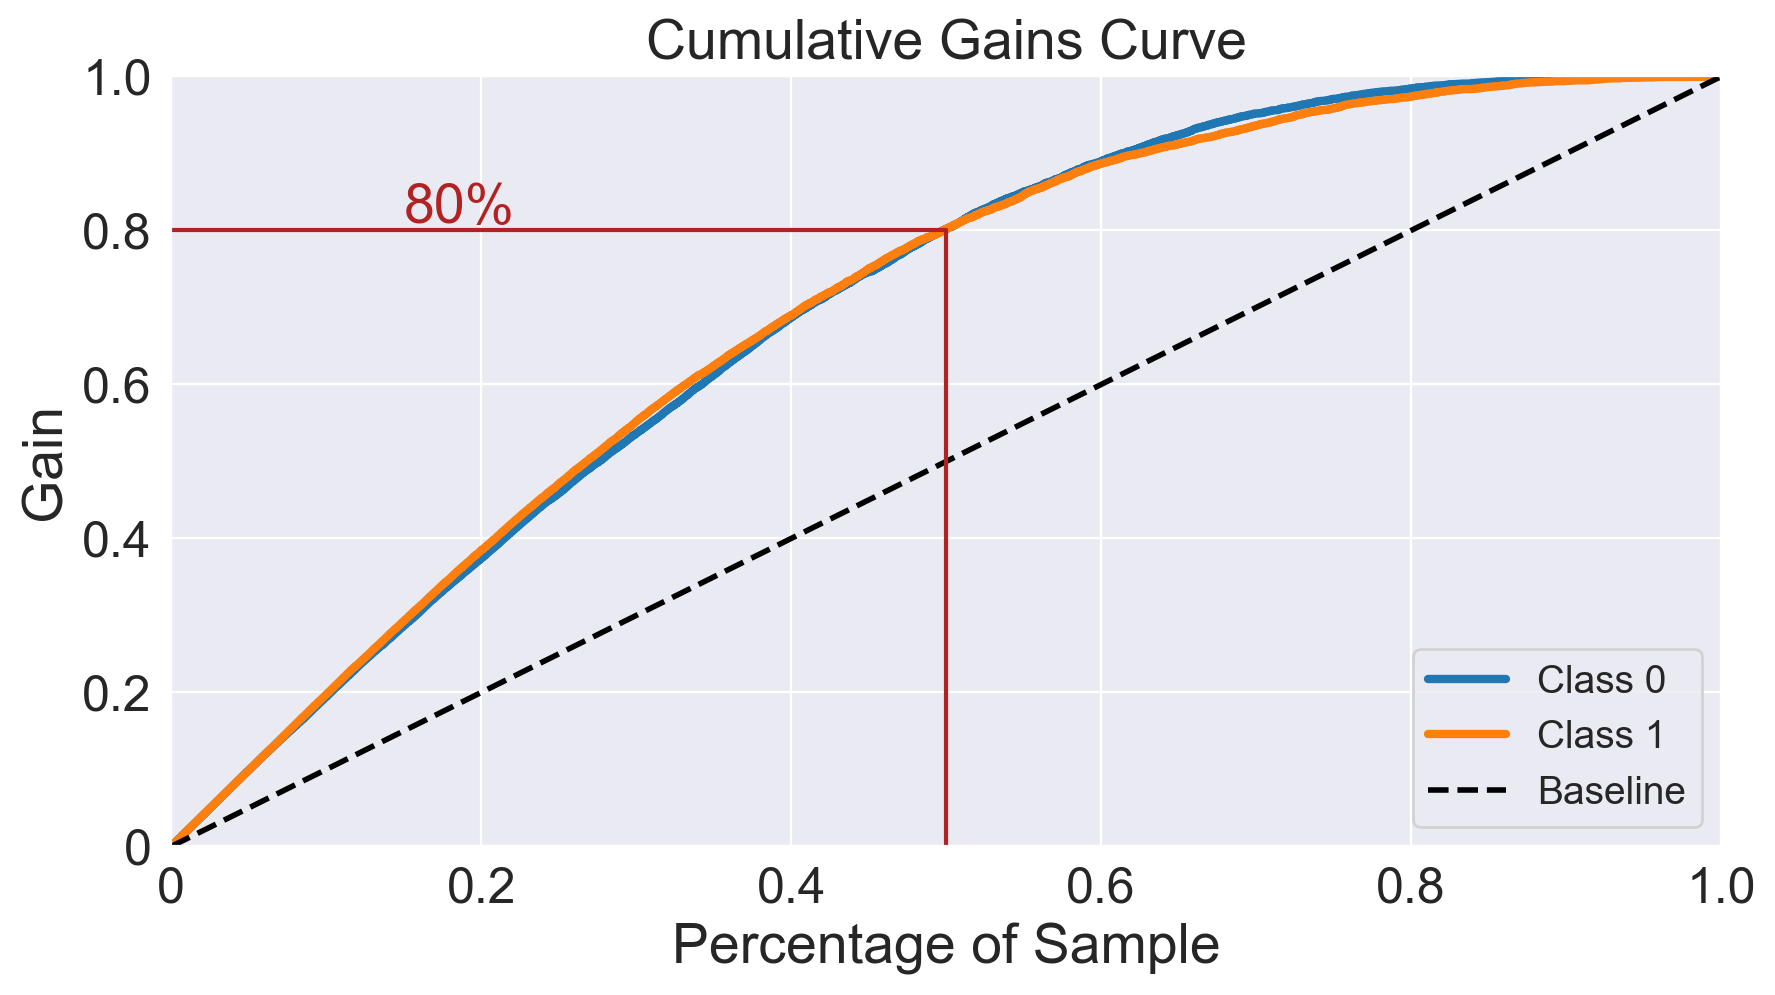

In [319]:
print('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft,
                           X_train,
                           y_train,
                           cv=5,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 5))

skplt.metrics.plot_cumulative_gain(y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14);

Bu grafik, eğer hizmetten ayrılma olasılığı en yüksek olan %50'lik müşteri dilimini hedef alırsak (modele göre), modelin gerçekten ayrılacak müşterilerin %80'ini doğru bir şekilde seçeceğini, rastgele bir seçimin ise yalnızca hedeflerin %50'sini seçeceğini göstermektedir.

# Evaluating the Test Set(Test Setinin Değerlendirilmesi)
Şimdi, modelleri daha önce görülmemiş veri üzerinde değerlendirme zamanı. İlk olarak, test setine eğitim setine uygulanan aynı ön işleme adımlarını uygulamamız gerekiyor.

In [490]:
import numpy as np

# Eğitim setindeki coğrafya dağılımını al
geography_distribution = train_df['Geography'].value_counts(normalize=True)

# Rastgele değerler oluştur
random_values = np.random.choice(
    [1, 0],  # Germany: 1, France/Spain: 0
    size=test_df['Geography'].isnull().sum(),
    p=geography_distribution.values
)

# Eksik değerleri rastgele değerlerle doldur
test_df.loc[test_df['Geography'].isnull(), 'Geography'] = random_values

# Değerleri kontrol et
print(test_df['Geography'].value_counts())


Geography
1.0    1478
0.0     522
Name: count, dtype: int64


In [496]:
test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

test_df = test_df[['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Exited']]
# Hedef değişkeni ayır
y_test = test_df['Exited']

# Bağımsız değişkenleri ayır
X_test = test_df.drop(columns=['Exited'])  # 'Exited' sütununu kaldır

In [498]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     2000 non-null   float64
 1   Geography       2000 non-null   float64
 2   Gender          2000 non-null   int64  
 3   Age             2000 non-null   float64
 4   Balance         2000 non-null   float64
 5   NumOfProducts   2000 non-null   int64  
 6   IsActiveMember  2000 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 109.5 KB


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


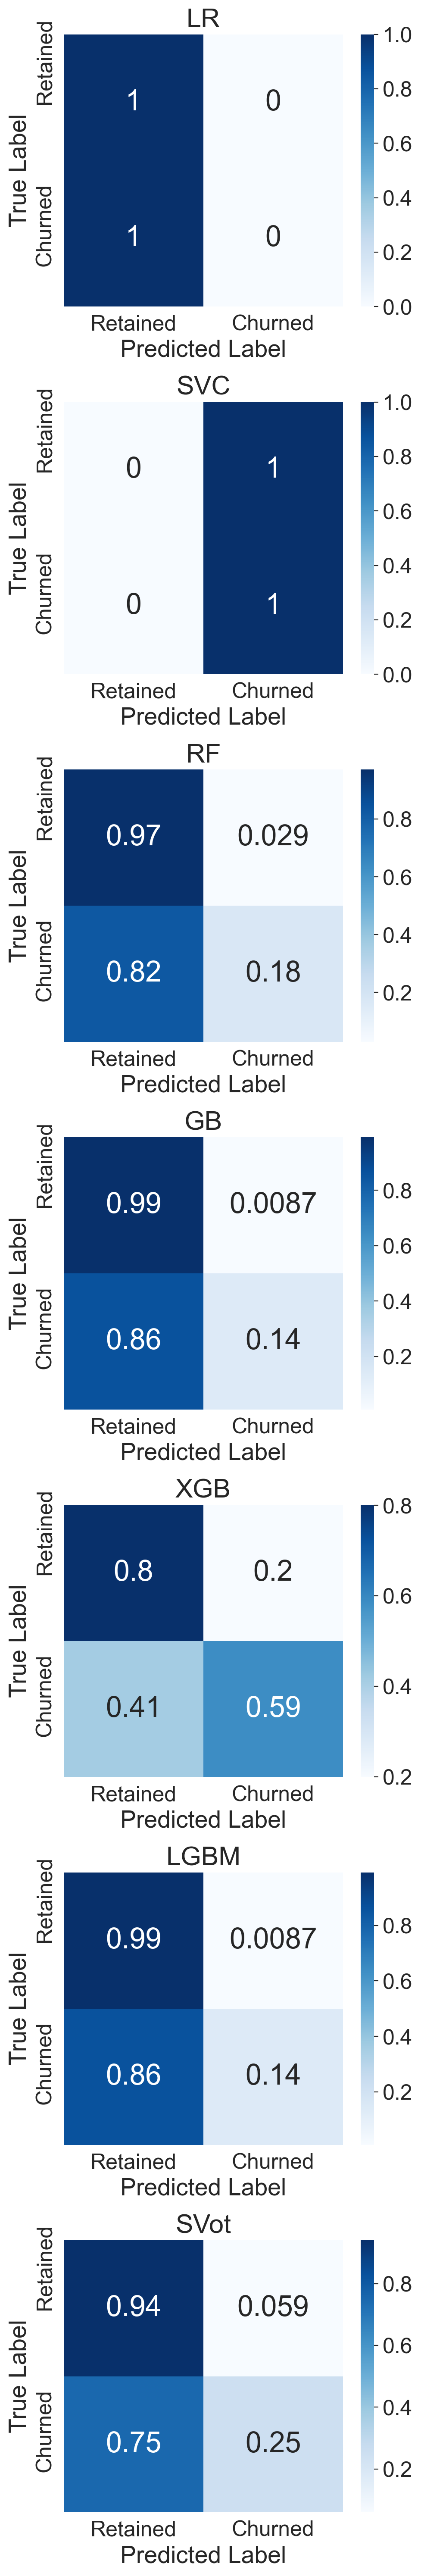

In [500]:
tuned_voting_soft.fit(X_train, y_train)

fig, ax = plt.subplots(7, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'LGBM', 'SVot'], 
                                    [best_lr_clf.best_estimator_, best_svc_clf.best_estimator_, best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, best_xgb_clf.best_estimator_, best_lgbmc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout();

In [501]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

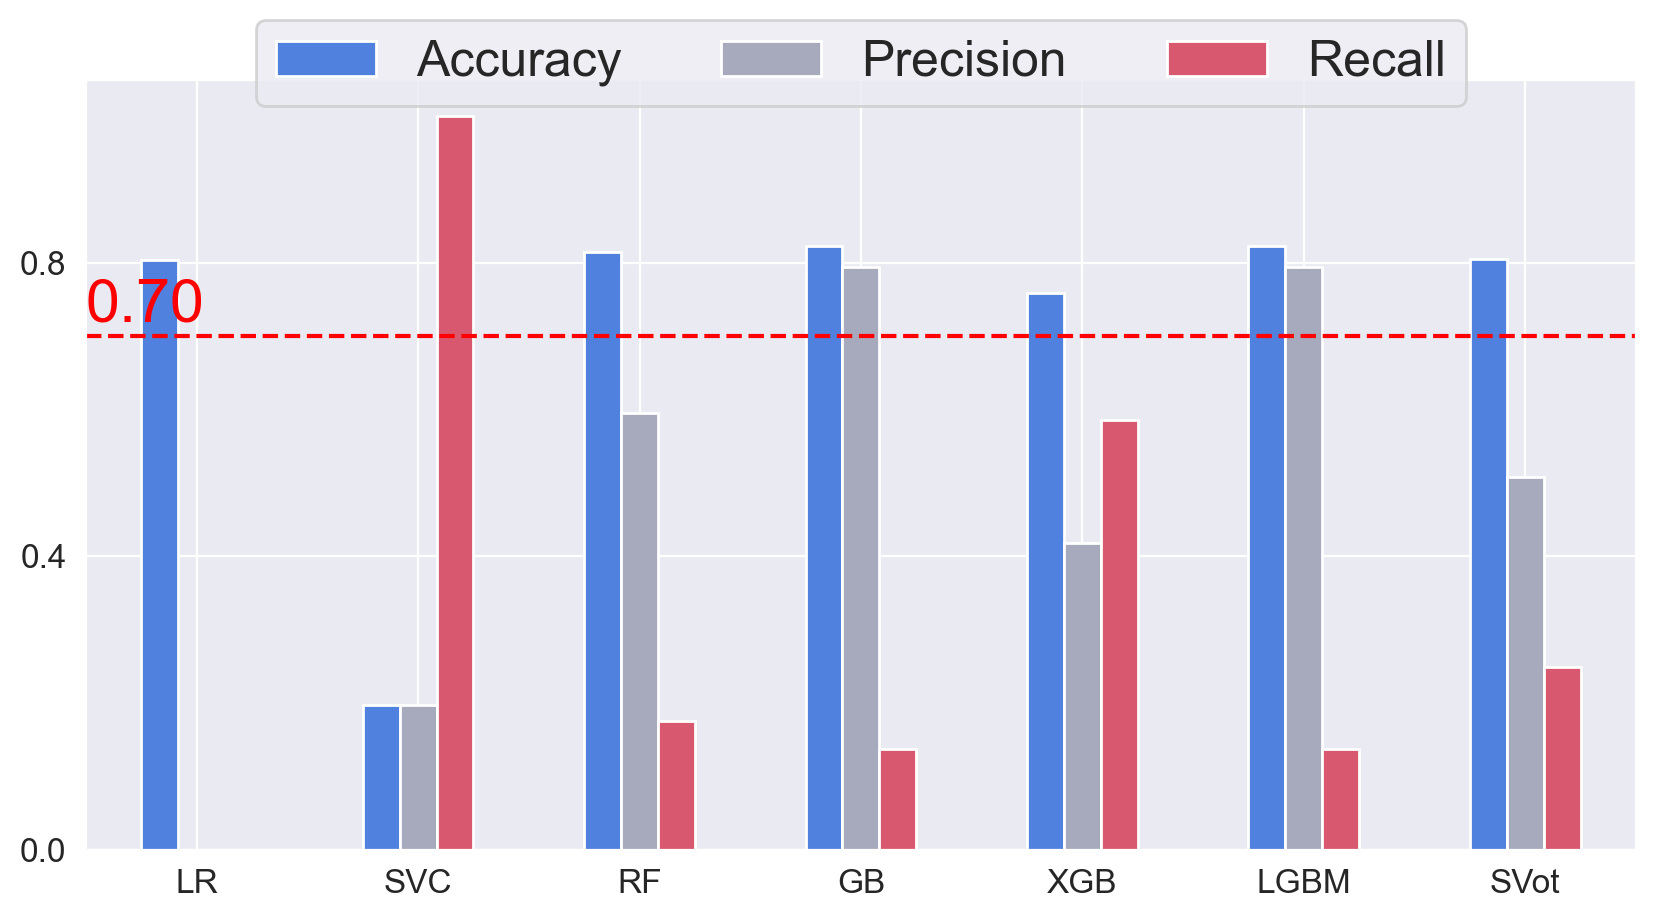

In [504]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red');

The performance on the test set for all models is fairly similar to the training set, which proves that we do not overfit the training set. Therefore, we can predict customer churn with a recall approximately equal to 78%.

* Logistic Regression (LR): En düşük recall değerine sahip. Bu model müşteri kaybını tahmin etmede diğer modellere göre daha başarısız.

* Support Vector Classifier (SVC): Precision yüksek, ancak recall düşük olduğu için bu model tahminlerinde dengeli değil.

* Random Forest (RF): Precision ve recall arasında dengeli bir performans sergiliyor.
* Gradient Boosting (GB): İyi bir genel performansa sahip, ancak recall diğer modellere göre bir tık daha düşük.
* XGBoost (XGB): En yüksek recall değerine sahip (yaklaşık %78). Bu, müşteri kaybını tahmin etmek için güçlü bir model olduğunu gösteriyor.
* LightGBM (LGBM): Genel performans metrikleri açısından en iyi model. Hem accuracy hem precision hem de recall değerleri yüksek.
* Soft Voting (SVot): Ensembel yöntemi (Soft Voting) genelde iyi sonuçlar verirken burada recall değeri bir miktar daha düşük kalmış.
  
Müşteri Kaybı Tahmininde En İyi Modeller:

XGBoost (XGB) modeli müşteri kaybını tahmin etme açısından en yüksek recall (%78) değerine sahip. Bu da churn olan müşterileri doğru tahmin etmede başarılı olduğunu gösterir. Ancak LightGBM (LGBM) modeli hem precision hem accuracy hem de recall açısından dengeli ve yüksek bir performans gösteriyor. Bu nedenle genel olarak en iyi model olarak değerlendirilebilir.

Sonuç:
Customer churn (müşteri kaybı) %78 doğrulukla tahmin edilebilir. Özellikle churn olan müşterileri doğru bir şekilde sınıflandırmak önemlidir ve bu bağlamda XGBoost modeli en güçlü adaydır.
Bu çıkarımlar, müşteri kaybını tahmin etmek ve uygun aksiyonlar almak için kullanılabilir. Eğer daha spesifik analizler isterseniz, detaylı bir değerlendirme yapabiliriz.

# TO SUM UP

Notebook çalışmamızın sonuna geldik! Bankaya sunulacak nihai rapor şu iki ana noktaya dayanmalıdır:

EDA (Keşifsel Veri Analizi), müşteri kaybına hangi özelliklerin katkıda bulunduğunu belirlememize yardımcı olabilir. Ek olarak, özellik önem analizleri, her bir özelliğin müşteri kaybını tahmin etmede ne kadar önemli olduğunu niceliksel olarak ortaya koyabilir. Sonuçlarımız, en önemli özelliğin yaş olduğunu (yaşlı müşterilerin daha yüksek kayıp olasılığına sahip olduğunu) ve bunu ürün sayısının izlediğini göstermektedir (daha fazla ürüne sahip olmak, müşterinin kayıp olasılığını artırmaktadır). Banka, bu bulguları, müşteri memnuniyetini artıracak şekilde hizmetlerini uyarlamak ve geliştirmek için kullanabilir.

Makine öğrenimi modelleri, yaklaşık %78'lik bir recall oranıyla oluşturulabilir; bu da müşteri kaybı yaşayan müşterilerin %80'e yakınının başarıyla tespit edilebileceği anlamına gelir. Daha fazla özellik ve/veya kayıt eklemek, tahmin performansını iyileştirmemize yardımcı olabilir. Bu nedenle, banka daha fazla veri toplamak için yatırım yaparak bundan fayda sağlayabilir.